**MICHIGAN WEATHER DATA**

In [1]:
import requests

BASE_URL = "https://www.ncei.noaa.gov/cdo-web/api/v2/"

API_TOKEN = "vQWJzlLfwQurSgRTAmHiAZvZnnRtXoYf"

headers = {
    "token": API_TOKEN
}

def fetch_all_locations():
    """Fetch all locations from NOAA API and return as a list."""
    locations = []
    limit = 1000
    offset = 1

    while True:
        params = {"limit": limit, "offset": offset}
        response = requests.get(BASE_URL + "locations", headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            locations.extend(data.get("results", []))

            if len(data.get("results", [])) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching locations: {response.status_code}, {response.text}")
            break

    return locations

def fetch_datatypes_for_location(location_id):
    """Fetch datatypes for a specific location."""
    datatypes = []
    limit = 1000
    offset = 1

    while True:
        params = {"limit": limit, "offset": offset, "locationid": location_id}
        response = requests.get(BASE_URL + "datatypes", headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            datatypes.extend(data.get("results", []))

            if len(data.get("results", [])) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching datatypes for {location_id}: {response.status_code}, {response.text}")
            break

    return datatypes

locations = fetch_all_locations()
michigan_locations = [loc for loc in locations if "Michigan" in loc['name']]

if not michigan_locations:
    print("No Michigan locations found.")
else:
    for loc in michigan_locations:
        print(f"ID: {loc['id']}, Name: {loc['name']}")

    michigan_location_id = michigan_locations[0]['id']

    michigan_datatypes = fetch_datatypes_for_location(michigan_location_id)

    print(f"Total datatypes for Michigan: {len(michigan_datatypes)}")
    for dtype in michigan_datatypes:
        print(f"ID: {dtype['id']}, Name: {dtype['name']}, Min Date: {dtype['mindate']}, Max Date: {dtype['maxdate']}")


ID: CITY:US180008, Name: Michigan City, IN US
ID: CLIM:2601, Name: West Upper Michigan Climate Division
ID: CLIM:2602, Name: East Upper Michigan Climate Division
ID: CLIM:2603, Name: Northwest Michigan Climate Division
ID: CLIM:2604, Name: Northeast Lower Michigan Climate Division
ID: CLIM:2605, Name: West Central Lower Michigan Climate Division
ID: CLIM:2606, Name: Central Lower Michigan Climate Division
ID: CLIM:2607, Name: East Central Lower Michigan Climate Division
ID: CLIM:2608, Name: Southwest Lower Michigan Climate Division
ID: CLIM:2609, Name: South Central Lower Michigan Climate Division
ID: CLIM:2610, Name: Southeast Lower Michigan Climate Division
ID: FIPS:26, Name: Michigan
ID: HUC:0403, Name: Northwestern Lake Michigan Hydrologic Unit
ID: HUC:040301, Name: Northwestern Lake Michigan Hydrologic Unit
ID: HUC:0404, Name: Southwestern Lake Michigan Hydrologic Unit
ID: HUC:040400, Name: Southwestern Lake Michigan Hydrologic Unit
ID: HUC:0405, Name: Southeastern Lake Michigan H

In [7]:
import requests
import csv
from datetime import datetime, timedelta

BASE_URL = "https://www.ncei.noaa.gov/cdo-web/api/v2/"

API_TOKEN = "vQWJzlLfwQurSgRTAmHiAZvZnnRtXoYf"

headers = {
    "token": API_TOKEN
}

def fetch_data_for_datatype(location_id, datatype_id, start_date, end_date, dataset_id):
    """Fetch data for a specific datatype, dataset, and time range."""
    data = []
    limit = 1000
    offset = 1

    while True:
        params = {
            "limit": limit,
            "offset": offset,
            "locationid": location_id,
            "datatypeid": datatype_id,
            "startdate": start_date,
            "enddate": end_date,
            "datasetid": dataset_id,
            "units": "metric"
        }
        response = requests.get(BASE_URL + "data", headers=headers, params=params)

        if response.status_code == 200:
            response_data = response.json()
            data.extend(response_data.get("results", []))

            if len(response_data.get("results", [])) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching data for {datatype_id}: {response.status_code}, {response.text}")
            break

    return data

def save_to_csv(data, filename):
    """Save the fetched data to a CSV file."""
    if not data:
        print("No data to save.")
        return

    keys = data[0].keys()
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)

    print(f"Data saved to {filename}")

def split_date_range_by_month(start_date, end_date):
    """Split a date range into monthly chunks."""
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    while start < end:
        next_month = (start.month % 12) + 1
        next_year = start.year + (1 if next_month == 1 else 0)
        chunk_end = datetime(next_year, next_month, 1) - timedelta(days=1)
        if chunk_end > end:
            chunk_end = end
        yield start.strftime("%Y-%m-%d"), chunk_end.strftime("%Y-%m-%d")
        start = chunk_end + timedelta(days=1)

#parameters
michigan_location_id = "FIPS:26"  #michigan ID
selected_datatypes = [
    {"id": "WT11", "name": "High or damaging winds", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "WT10", "name": "Tornado, waterspout", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "WT01", "name": "Fog, ice fog, or freezing fog", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "WT03", "name": "Thunder", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "MDPR", "name": "Multiday precipitation total", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "MDSF", "name": "Multiday snowfall total", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "TAVG", "name": "Average Temperature", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "TMAX", "name": "Maximum Temperature", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "TMIN", "name": "Minimum Temperature", "start_date": "2020-01-01", "end_date": "2023-12-31"}
]


dataset_id = "GHCND"

data_to_save = []
for datatype in selected_datatypes:
    datatype_id = datatype["id"]
    name = datatype["name"]
    start_date = datatype.get("start_date", "2020-01-01")
    end_date = datatype.get("end_date", "2023-12-31")

    print(f"Fetching data for {datatype_id} ({name})...")
    for chunk_start, chunk_end in split_date_range_by_month(start_date, end_date):
        print(f"  Date range: {chunk_start} to {chunk_end}")
        data = fetch_data_for_datatype(michigan_location_id, datatype_id, chunk_start, chunk_end, dataset_id)

        for record in data:
            record["datatype"] = name  # Add datatype name to the record

        data_to_save.extend(data)

save_to_csv(data_to_save, "michigan_weather_data.csv")

Fetching data for WT11 (High or damaging winds)...
  Date range: 2020-01-01 to 2020-01-31
  Date range: 2020-02-01 to 2020-02-29
  Date range: 2020-03-01 to 2020-03-31
  Date range: 2020-04-01 to 2020-04-30
  Date range: 2020-05-01 to 2020-05-31
  Date range: 2020-06-01 to 2020-06-30
  Date range: 2020-07-01 to 2020-07-31
  Date range: 2020-08-01 to 2020-08-31
  Date range: 2020-09-01 to 2020-09-30
  Date range: 2020-10-01 to 2020-10-31
  Date range: 2020-11-01 to 2020-11-30
  Date range: 2020-12-01 to 2020-12-31
  Date range: 2021-01-01 to 2021-01-31
  Date range: 2021-02-01 to 2021-02-28
  Date range: 2021-03-01 to 2021-03-31
  Date range: 2021-04-01 to 2021-04-30
  Date range: 2021-05-01 to 2021-05-31
  Date range: 2021-06-01 to 2021-06-30
  Date range: 2021-07-01 to 2021-07-31
  Date range: 2021-08-01 to 2021-08-31
  Date range: 2021-09-01 to 2021-09-30
  Date range: 2021-10-01 to 2021-10-31
  Date range: 2021-11-01 to 2021-11-30
  Date range: 2021-12-01 to 2021-12-31
  Date range:

In [10]:
import pandas as pd

df = pd.read_csv("michigan_weather_data.csv")

print("Unique datatypes in the dataset:\n", df['datatype'].unique())

temperature_data = df[df['datatype'].isin(['TAVG', 'TMAX', 'TMIN'])]

print("Sample rows for TAVG, TMAX, and TMIN:")
print(temperature_data.head(20))

print("\nStatistics for temperature data (TAVG, TMAX, TMIN):")
print(temperature_data['value'].describe())


Unique datatypes in the dataset:
 ['High or damaging winds' 'Tornado, waterspout'
 'Fog, ice fog, or freezing fog' 'Thunder' 'Multiday precipitation total'
 'Average Temperature' 'Maximum Temperature' 'Minimum Temperature']
Sample rows for TAVG, TMAX, and TMIN:
Empty DataFrame
Columns: [date, datatype, station, attributes, value]
Index: []

Statistics for temperature data (TAVG, TMAX, TMIN):
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64


In [11]:
temperature_data = df[df['datatype'].isin(['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'])]

print("Sample rows for Average, Maximum, and Minimum Temperature:")
print(temperature_data.head(20))

print("\nStatistics for temperature data:")
print(temperature_data['value'].describe())


Sample rows for Average, Maximum, and Minimum Temperature:
                      date             datatype            station attributes  \
36308  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MBAL       ,,U,   
36309  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MBRR       ,,U,   
36310  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MDOE       ,,U,   
36311  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MMIO       ,,U,   
36312  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MRAC       ,,U,   
36313  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MSEN       ,,U,   
36314  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MSPI       ,,U,   
36315  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MWAT       ,,U,   
36316  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000MWDO       ,,U,   
36317  2020-01-01T00:00:00  Average Temperature  GHCND:USW00014826      H,,S,   
36318  2020-01-01T00:00:00  Average Temperature  G

<ipython-input-12-5054ca539918>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['value'] = temperature_data['value'] / 10.0  # Adjust based on NOAA's unit standards


Sample of 'High or damaging winds':
        date                datatype            station attributes  value
0 2020-01-01  High or damaging winds  GHCND:USC00203661       ,,7,    1.0
1 2020-01-03  High or damaging winds  GHCND:USC00206354       ,,7,    1.0
2 2020-01-05  High or damaging winds  GHCND:USC00200228       ,,7,    1.0
3 2020-01-05  High or damaging winds  GHCND:USC00200230       ,,7,    1.0
4 2020-01-06  High or damaging winds  GHCND:USC00200228       ,,7,    1.0
5 2020-01-06  High or damaging winds  GHCND:USC00200230       ,,7,    1.0
6 2020-01-09  High or damaging winds  GHCND:USC00200228       ,,7,    1.0
7 2020-01-09  High or damaging winds  GHCND:USC00200230       ,,7,    1.0
8 2020-01-11  High or damaging winds  GHCND:USC00200228       ,,7,    1.0
9 2020-01-11  High or damaging winds  GHCND:USC00200230       ,,7,    1.0


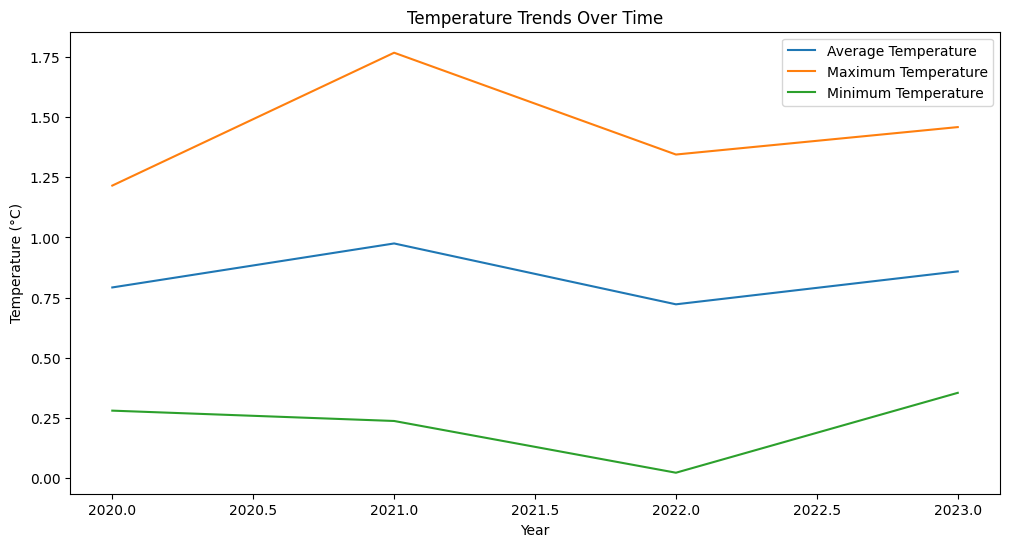

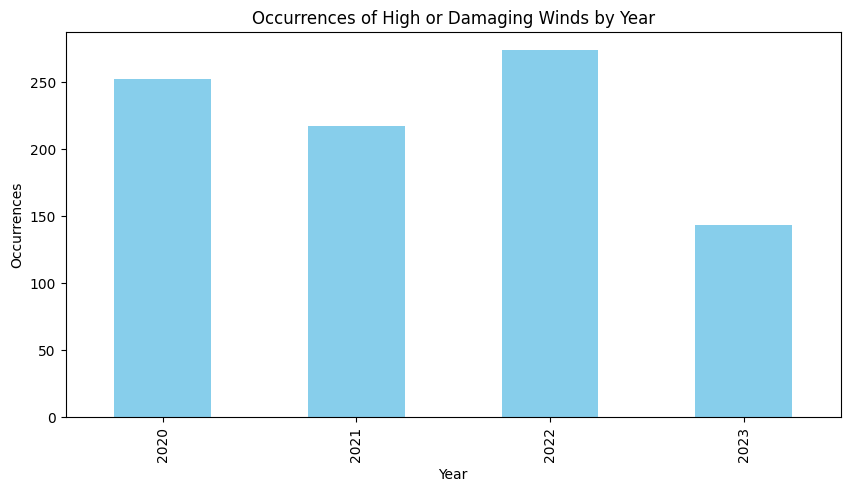

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("michigan_weather_data.csv")

df['date'] = pd.to_datetime(df['date'])

temperature_data = df[df['datatype'].isin(['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'])]

temperature_data['value'] = temperature_data['value'] / 10.0  # Adjust based on NOAA's unit standards

print("Sample of 'High or damaging winds':")
print(df[df['datatype'] == 'High or damaging winds'].head(10))

grouped_temp = temperature_data.groupby(['datatype', df['date'].dt.year])['value'].mean().reset_index()

plt.figure(figsize=(12, 6))
for dtype in ['Average Temperature', 'Maximum Temperature', 'Minimum Temperature']:
    subset = grouped_temp[grouped_temp['datatype'] == dtype]
    plt.plot(subset['date'], subset['value'], label=dtype)

plt.title('Temperature Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

event_data = df[df['datatype'] == 'High or damaging winds']
event_counts = event_data.groupby(event_data['date'].dt.year)['value'].sum()

plt.figure(figsize=(10, 5))
event_counts.plot(kind='bar', color='skyblue')
plt.title('Occurrences of High or Damaging Winds by Year')
plt.xlabel('Year')
plt.ylabel('Occurrences')
plt.show()


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510374 entries, 0 to 510373
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        510374 non-null  datetime64[ns]
 1   datatype    510374 non-null  object        
 2   station     510374 non-null  object        
 3   attributes  510374 non-null  object        
 4   value       510374 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 19.5+ MB
None

Sample Data:
        date                datatype            station attributes  value
0 2020-01-01  High or damaging winds  GHCND:USC00203661       ,,7,    1.0
1 2020-01-03  High or damaging winds  GHCND:USC00206354       ,,7,    1.0
2 2020-01-05  High or damaging winds  GHCND:USC00200228       ,,7,    1.0
3 2020-01-05  High or damaging winds  GHCND:USC00200230       ,,7,    1.0
4 2020-01-06  High or damaging winds  GHCND:USC00200228       ,,7,  

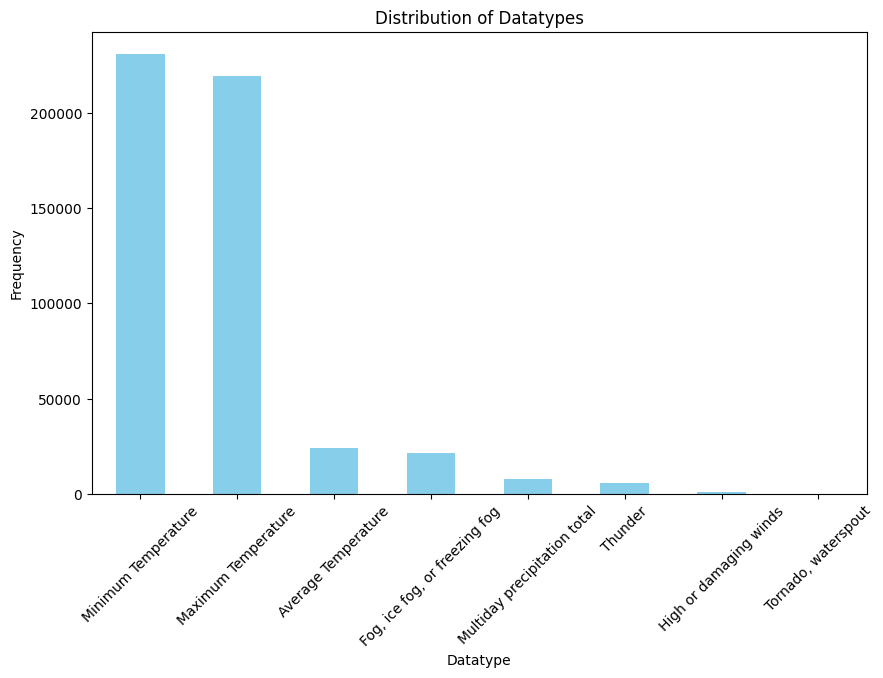

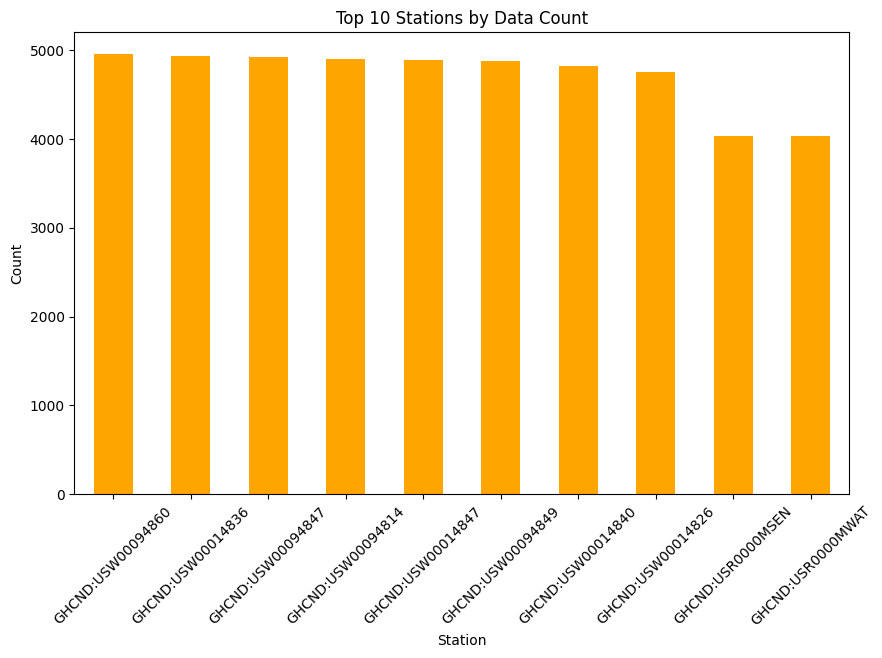

<ipython-input-13-4c66fcc1a733>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['value'] = temperature_data['value'] / 10.0  # Convert tenths of °C to °C
<ipython-input-13-4c66fcc1a733>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['month'] = temperature_data['date'].dt.month
<ipython-input-13-4c66fcc1a733>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

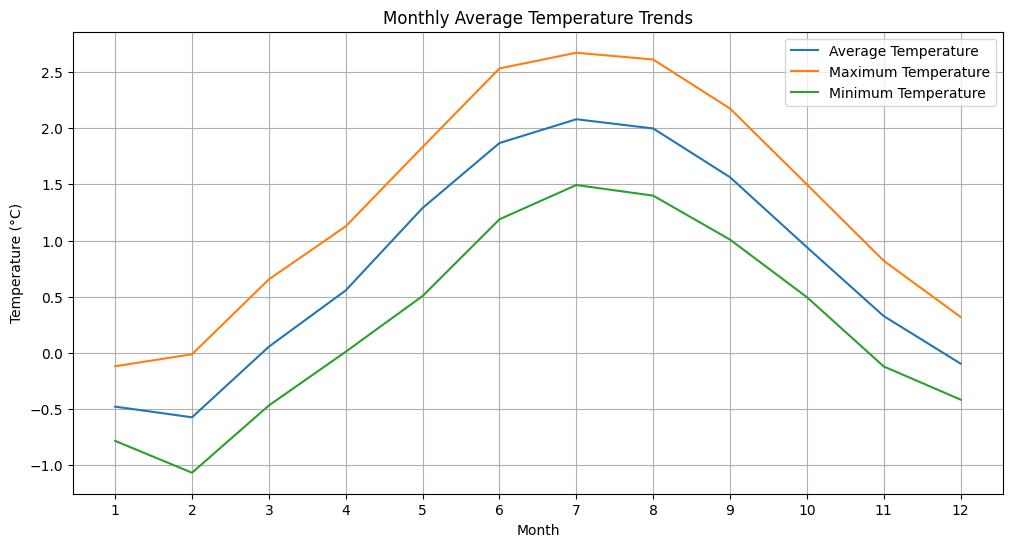

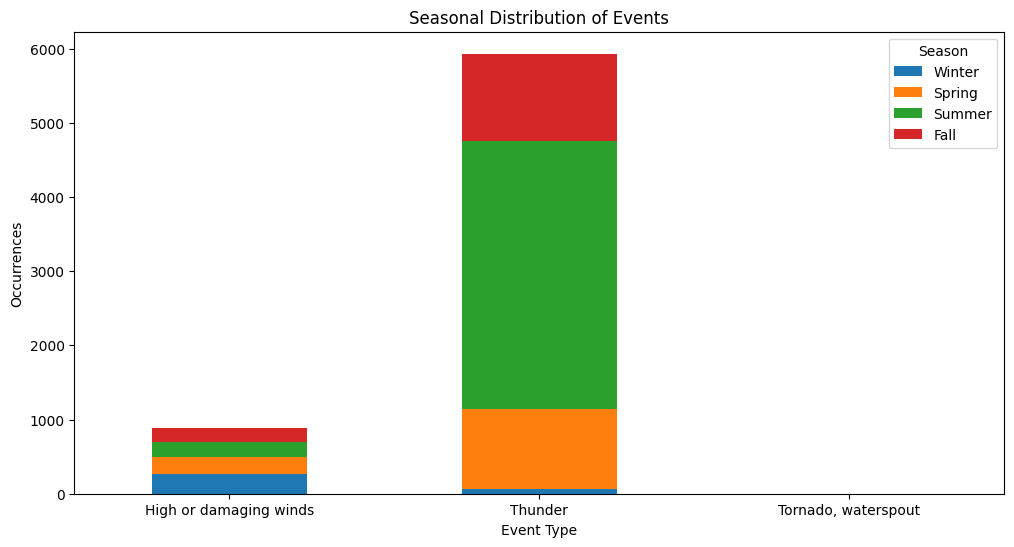

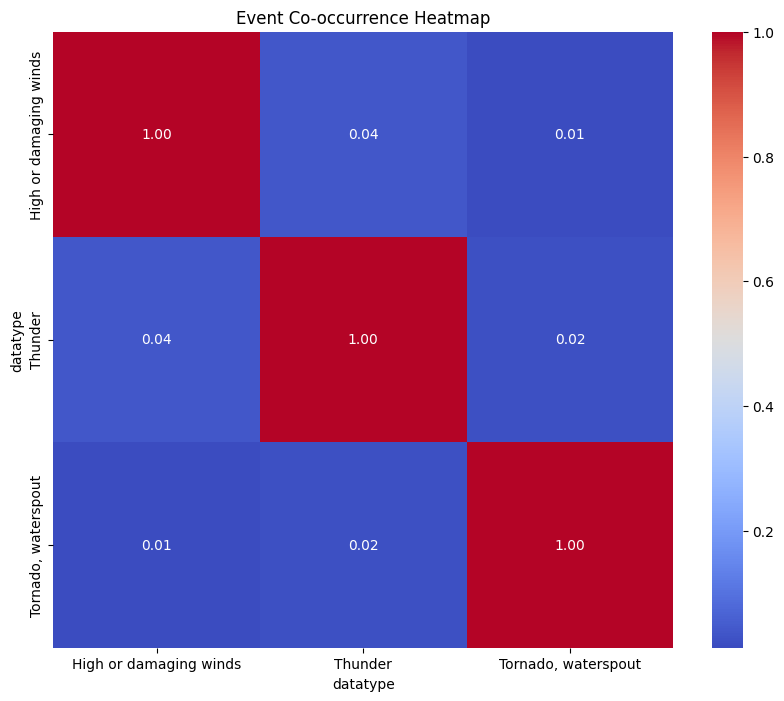

Top 10 Stations with Highest Recorded Temperatures:
station
GHCND:USC00203477    3.89
GHCND:USC00205451    3.72
GHCND:USC00200106    3.72
GHCND:USC00204280    3.72
GHCND:USW00014853    3.72
GHCND:USC00200770    3.72
GHCND:USC00200710    3.67
GHCND:USC00207312    3.67
GHCND:USC00203295    3.67
GHCND:USW00014836    3.67
Name: value, dtype: float64


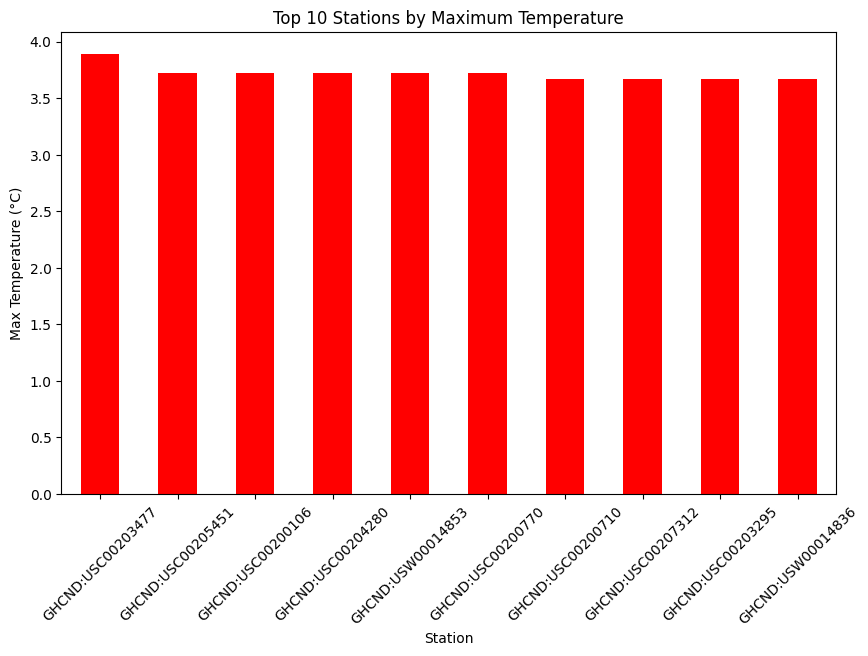

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("michigan_weather_data.csv")
df['date'] = pd.to_datetime(df['date'])

print("Dataset Overview:")
print(df.info())
print("\nSample Data:")
print(df.head())

datatype_counts = df['datatype'].value_counts()
plt.figure(figsize=(10, 6))
datatype_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Datatypes')
plt.xlabel('Datatype')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

station_counts = df['station'].value_counts().head(10)
plt.figure(figsize=(10, 6))
station_counts.plot(kind='bar', color='orange')
plt.title('Top 10 Stations by Data Count')
plt.xlabel('Station')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

temperature_data = df[df['datatype'].isin(['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'])]
temperature_data['value'] = temperature_data['value'] / 10.0  # Convert tenths of °C to °C
temperature_data['month'] = temperature_data['date'].dt.month
temperature_data['year'] = temperature_data['date'].dt.year

monthly_avg = temperature_data.groupby(['datatype', 'month'])['value'].mean().reset_index()
plt.figure(figsize=(12, 6))
for dtype in ['Average Temperature', 'Maximum Temperature', 'Minimum Temperature']:
    subset = monthly_avg[monthly_avg['datatype'] == dtype]
    plt.plot(subset['month'], subset['value'], label=dtype)
plt.legend()
plt.title('Monthly Average Temperature Trends')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.xticks(range(1, 13))
plt.grid()
plt.show()

df['season'] = df['date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Fall
event_data = df[df['datatype'].isin(['High or damaging winds', 'Thunder', 'Tornado, waterspout'])]
seasonal_events = event_data.groupby(['datatype', 'season'])['value'].sum().unstack()

seasonal_events.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Seasonal Distribution of Events')
plt.xlabel('Event Type')
plt.ylabel('Occurrences')
plt.xticks(rotation=0)
plt.legend(title='Season', labels=['Winter', 'Spring', 'Summer', 'Fall'])
plt.show()

event_matrix = pd.crosstab(event_data['date'], event_data['datatype'])
event_corr = event_matrix.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(event_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Event Co-occurrence Heatmap')
plt.show()

extreme_temps = temperature_data[temperature_data['datatype'] == 'Maximum Temperature']
top_stations = extreme_temps.groupby('station')['value'].max().sort_values(ascending=False).head(10)
print("Top 10 Stations with Highest Recorded Temperatures:")
print(top_stations)

plt.figure(figsize=(10, 6))
top_stations.plot(kind='bar', color='red')
plt.title('Top 10 Stations by Maximum Temperature')
plt.xlabel('Station')
plt.ylabel('Max Temperature (°C)')
plt.xticks(rotation=45)
plt.show()


In [14]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("michigan_weather_data.csv")
df['date'] = pd.to_datetime(df['date'])

temperature_data = df[df['datatype'].isin(['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'])]
temperature_data['value'] = temperature_data['value'] / 10.0  # Convert tenths of °C to °C
temperature_data['month'] = temperature_data['date'].dt.to_period('M')

pivot_temp = temperature_data.pivot_table(index='month', columns='datatype', values='value', aggfunc='mean').reset_index()
pivot_temp['month'] = pivot_temp['month'].dt.to_timestamp()

fig = px.line(
    pivot_temp,
    x='month',
    y=['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'],
    labels={'value': 'Temperature (°C)', 'month': 'Month'},
    title='Temperature Trends Over Time',
)
fig.update_traces(mode='lines+markers')
fig.update_layout(legend_title_text='Temperature Type', xaxis_title='Date', yaxis_title='Temperature (°C)')
fig.show()


<ipython-input-14-ff708824f50a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['value'] = temperature_data['value'] / 10.0  # Convert tenths of °C to °C
<ipython-input-14-ff708824f50a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['month'] = temperature_data['date'].dt.to_period('M')


<ipython-input-24-9f394d3e37d1>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-9f394d3e37d1>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-9f394d3e37d1>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-24-9f39

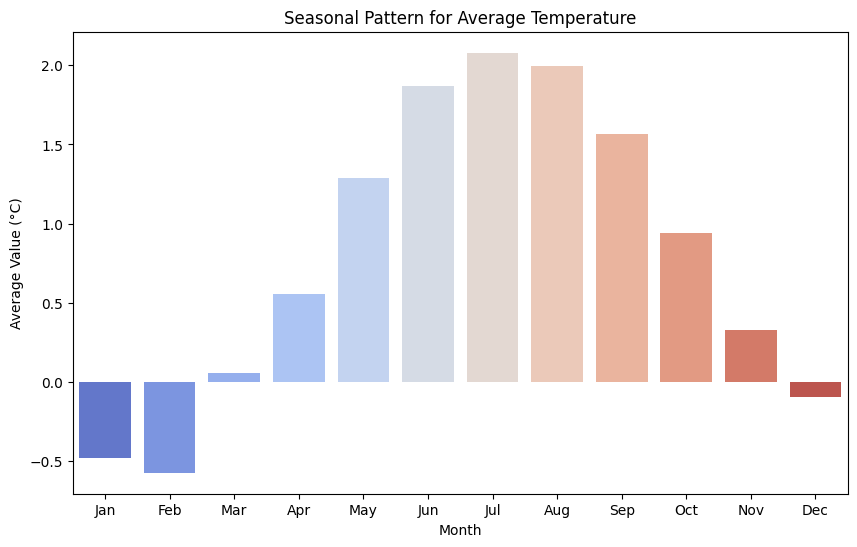

<ipython-input-24-9f394d3e37d1>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




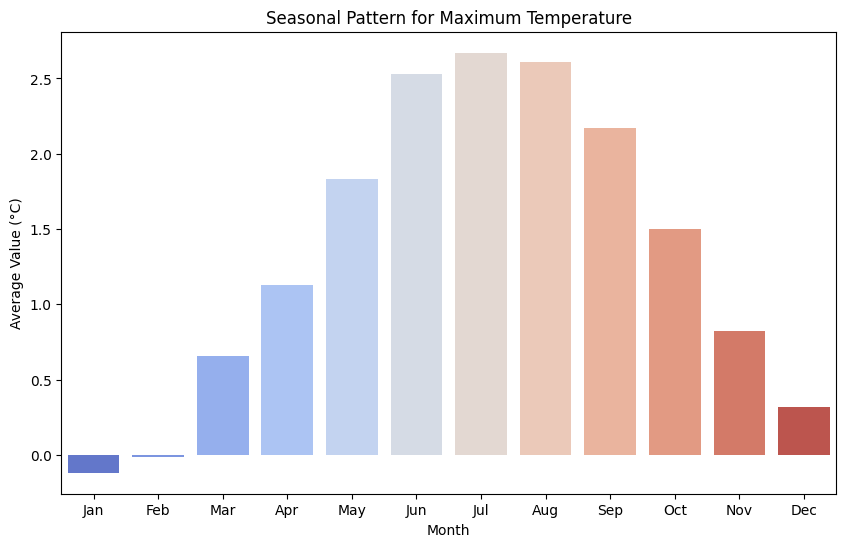

<ipython-input-24-9f394d3e37d1>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




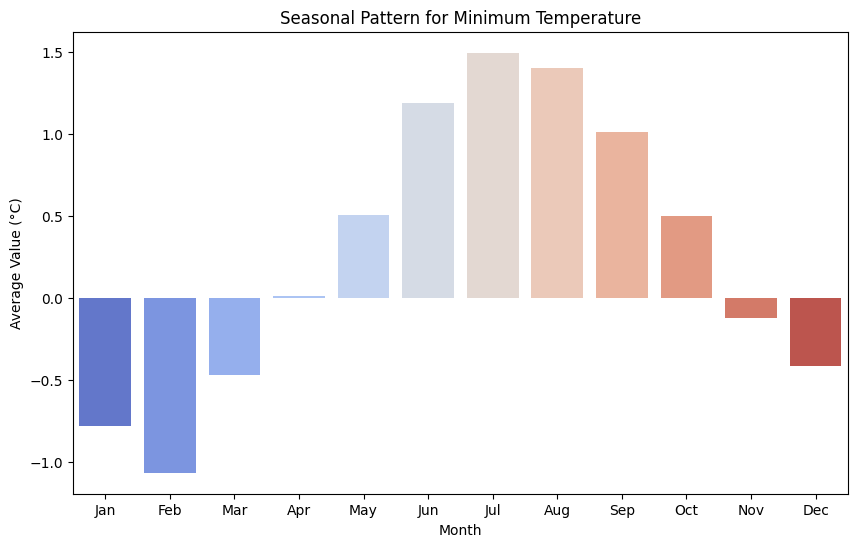

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("michigan_weather_data.csv")
df['date'] = pd.to_datetime(df['date'])

temperature_data = df[df['datatype'].isin(['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'])]
temperature_data['value'] = temperature_data['value'] / 10.0

temperature_data['month'] = temperature_data['date'].dt.to_period('M')
temperature_data['month_only'] = temperature_data['date'].dt.month
temperature_data['year'] = temperature_data['date'].dt.year

monthly_avg = temperature_data.groupby(['datatype', 'month_only'])['value'].mean().reset_index()

for datatype in ['Average Temperature', 'Maximum Temperature', 'Minimum Temperature']:
    seasonal_data = monthly_avg[monthly_avg['datatype'] == datatype]
    plt.figure(figsize=(10, 6))
    sns.barplot(data=seasonal_data, x='month_only', y='value', palette='coolwarm')
    plt.title(f"Seasonal Pattern for {datatype}")
    plt.xlabel("Month")
    plt.ylabel("Average Value (°C)")
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()



**FLORIDA**

In [25]:
import requests

BASE_URL = "https://www.ncei.noaa.gov/cdo-web/api/v2/"

API_TOKEN = "vQWJzlLfwQurSgRTAmHiAZvZnnRtXoYf"

headers = {
    "token": API_TOKEN
}

def fetch_datatypes_for_location(location_id):
    """Fetch datatypes available for a specific location."""
    datatypes = []
    limit = 1000
    offset = 1

    while True:
        params = {
            "locationid": location_id,
            "limit": limit,
            "offset": offset
        }
        response = requests.get(BASE_URL + "datatypes", headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            datatypes.extend(data.get("results", []))

            if len(data.get("results", [])) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching datatypes: {response.status_code}, {response.text}")
            break

    return datatypes

florida_datatypes = fetch_datatypes_for_location("FIPS:12")

print(f"Total datatypes for Florida: {len(florida_datatypes)}")
for dtype in florida_datatypes:
    print(f"ID: {dtype['id']}, Name: {dtype['name']}, Min Date: {dtype['mindate']}, Max Date: {dtype['maxdate']}")


Total datatypes for Florida: 904
ID: ACMH, Name: Average cloudiness midnight to midnight from manual observations, Min Date: 1965-01-01, Max Date: 2005-12-31
ID: ACSH, Name: Average cloudiness sunrise to sunset from manual observations, Min Date: 1965-01-01, Max Date: 2005-12-31
ID: ALL, Name: Base Data, Min Date: 1991-06-05, Max Date: 2024-12-10
ID: ANN-CLDD-BASE45, Name: Long-term averages of annual cooling degree days with base 45F, Min Date: 2010-01-01, Max Date: 2010-01-01
ID: ANN-CLDD-BASE50, Name: Long-term averages of annual cooling degree days with base 50F, Min Date: 2010-01-01, Max Date: 2010-01-01
ID: ANN-CLDD-BASE55, Name: Long-term averages of annual cooling degree days with base 55F, Min Date: 2010-01-01, Max Date: 2010-01-01
ID: ANN-CLDD-BASE57, Name: Long-term averages of annual cooling degree days with base 57F, Min Date: 2010-01-01, Max Date: 2010-01-01
ID: ANN-CLDD-BASE60, Name: Long-term averages of annual cooling degree days with base 60F, Min Date: 2010-01-01, Ma

In [27]:
import requests

BASE_URL = "https://www.ncei.noaa.gov/cdo-web/api/v2/"

API_TOKEN = "vQWJzlLfwQurSgRTAmHiAZvZnnRtXoYf"

headers = {
    "token": API_TOKEN
}

def fetch_datasets():
    """Fetch all available datasets from NOAA API."""
    datasets = []
    limit = 1000
    offset = 1

    while True:
        params = {
            "limit": limit,
            "offset": offset
        }
        response = requests.get(BASE_URL + "datasets", headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            datasets.extend(data.get("results", []))

            if len(data.get("results", [])) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching datasets: {response.status_code}, {response.text}")
            break

    return datasets

datasets = fetch_datasets()

print(f"Total datasets available: {len(datasets)}")
for dataset in datasets:
    print(f"ID: {dataset.get('id', 'N/A')}, "
          f"Name: {dataset.get('name', 'N/A')}, "
          f"Description: {dataset.get('description', 'No description available')}, "
          f"Min Date: {dataset.get('mindate', 'N/A')}, "
          f"Max Date: {dataset.get('maxdate', 'N/A')}")



Total datasets available: 11
ID: GHCND, Name: Daily Summaries, Description: No description available, Min Date: 1750-02-01, Max Date: 2024-12-09
ID: GSOM, Name: Global Summary of the Month, Description: No description available, Min Date: 1750-02-01, Max Date: 2024-11-01
ID: GSOY, Name: Global Summary of the Year, Description: No description available, Min Date: 1763-01-01, Max Date: 2024-01-01
ID: NEXRAD2, Name: Weather Radar (Level II), Description: No description available, Min Date: 1991-06-05, Max Date: 2024-12-10
ID: NEXRAD3, Name: Weather Radar (Level III), Description: No description available, Min Date: 1994-05-20, Max Date: 2024-12-07
ID: NORMAL_ANN, Name: Normals Annual/Seasonal, Description: No description available, Min Date: 2010-01-01, Max Date: 2010-01-01
ID: NORMAL_DLY, Name: Normals Daily, Description: No description available, Min Date: 2010-01-01, Max Date: 2010-12-31
ID: NORMAL_HLY, Name: Normals Hourly, Description: No description available, Min Date: 2010-01-01, 

In [35]:
import requests

BASE_URL = "https://www.ncei.noaa.gov/cdo-web/api/v2/"

API_TOKEN = "vQWJzlLfwQurSgRTAmHiAZvZnnRtXoYf"

headers = {
    "token": API_TOKEN
}

def fetch_datatypes_for_weather_radar(location_id, dataset_id):
    """Fetch available datatypes for a specific dataset and location."""
    datatypes = []
    limit = 1000
    offset = 1

    while True:

        params = {
            "locationid": location_id,
            "datasetid": dataset_id,
            "limit": limit,
            "offset": offset
        }
        response = requests.get(BASE_URL + "datatypes", headers=headers, params=params)

        if response.status_code == 200:
            data = response.json()
            datatypes.extend(data.get("results", []))

            if len(data.get("results", [])) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching datatypes: {response.status_code}, {response.text}")
            break

    return datatypes

dataset_id = "GHCND"
location_id = "FIPS:12"
florida_radar_datatypes = fetch_datatypes_for_weather_radar(location_id, dataset_id)

print(f"Total weather radar datatypes for Florida: {len(florida_radar_datatypes)}")
for dtype in florida_radar_datatypes:
    print(f"ID: {dtype['id']}, Name: {dtype['name']}, Min Date: {dtype['mindate']}, Max Date: {dtype['maxdate']}")


Total weather radar datatypes for Florida: 79
ID: ACMH, Name: Average cloudiness midnight to midnight from manual observations, Min Date: 1965-01-01, Max Date: 2005-12-31
ID: ACSH, Name: Average cloudiness sunrise to sunset from manual observations, Min Date: 1965-01-01, Max Date: 2005-12-31
ID: AWND, Name: Average wind speed, Min Date: 1982-01-01, Max Date: 2024-12-08
ID: DAEV, Name: Number of days included in the multiday evaporation total (MDEV), Min Date: 1948-08-02, Max Date: 2012-07-23
ID: DAPR, Name: Number of days included in the multiday precipitation total (MDPR), Min Date: 1750-02-01, Max Date: 2024-12-09
ID: DASF, Name: Number of days included in the multiday snow fall total (MDSF) , Min Date: 1877-01-02, Max Date: 2023-01-17
ID: DAWM, Name: Number of days included in the multiday wind movement (MDWM), Min Date: 1935-09-23, Max Date: 2010-06-21
ID: EVAP, Name: Evaporation of water from evaporation pan, Min Date: 1893-01-09, Max Date: 2024-10-31
ID: FMTM, Name: Time of faste

In [1]:
import requests
import csv
from datetime import datetime, timedelta

BASE_URL = "https://www.ncei.noaa.gov/cdo-web/api/v2/"

API_TOKEN = "vQWJzlLfwQurSgRTAmHiAZvZnnRtXoYf"

headers = {
    "token": API_TOKEN
}

def fetch_data_for_datatype(location_id, datatype_id, start_date, end_date, dataset_id):
    """Fetch data for a specific datatype, dataset, and time range."""
    data = []
    limit = 1000
    offset = 1

    while True:
        params = {
            "limit": limit,
            "offset": offset,
            "locationid": location_id,
            "datatypeid": datatype_id,
            "startdate": start_date,
            "enddate": end_date,
            "datasetid": dataset_id,
            "units": "metric"
        }
        response = requests.get(BASE_URL + "data", headers=headers, params=params)

        if response.status_code == 200:
            response_data = response.json()
            data.extend(response_data.get("results", []))

            if len(response_data.get("results", [])) < limit:
                break
            offset += limit
        else:
            print(f"Error fetching data for {datatype_id}: {response.status_code}, {response.text}")
            break

    return data

def save_to_csv(data, filename):
    """Save the fetched data to a CSV file."""
    if not data:
        print("No data to save.")
        return

    keys = data[0].keys()
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)

    print(f"Data saved to {filename}")

def split_date_range_by_month(start_date, end_date):
    """Split a date range into monthly chunks."""
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    while start < end:
        next_month = (start.month % 12) + 1
        next_year = start.year + (1 if next_month == 1 else 0)
        chunk_end = datetime(next_year, next_month, 1) - timedelta(days=1)
        if chunk_end > end:
            chunk_end = end
        yield start.strftime("%Y-%m-%d"), chunk_end.strftime("%Y-%m-%d")
        start = chunk_end + timedelta(days=1)

florida_location_id = "FIPS:12"  # Florida ID
selected_datatypes = [
    {"id": "TAVG", "name": "Average Temperature", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "TMAX", "name": "Maximum Temperature", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "TMIN", "name": "Minimum Temperature", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "PRCP", "name": "Precipitation", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "WT03", "name": "Thunder", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "WT10", "name": "Tornado, waterspout", "start_date": "2020-01-01", "end_date": "2023-12-31"},
    {"id": "WT11", "name": "High or damaging winds", "start_date": "2020-01-01", "end_date": "2023-12-31"}
]

dataset_id = "GHCND"

data_to_save = []
for datatype in selected_datatypes:
    datatype_id = datatype["id"]
    name = datatype["name"]
    start_date = datatype.get("start_date", "2020-01-01")
    end_date = datatype.get("end_date", "2023-12-31")

    print(f"Fetching data for {datatype_id} ({name})...")
    for chunk_start, chunk_end in split_date_range_by_month(start_date, end_date):
        print(f"  Date range: {chunk_start} to {chunk_end}")
        data = fetch_data_for_datatype(florida_location_id, datatype_id, chunk_start, chunk_end, dataset_id)

        for record in data:
            record["datatype"] = name

        data_to_save.extend(data)

save_to_csv(data_to_save, "florida_weather_data.csv")


Fetching data for TAVG (Average Temperature)...
  Date range: 2020-01-01 to 2020-01-31
  Date range: 2020-02-01 to 2020-02-29
  Date range: 2020-03-01 to 2020-03-31
  Date range: 2020-04-01 to 2020-04-30
Error fetching data for TAVG: 503, <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>503 Service Unavailable</title>
</head><body>
<h1>Service Unavailable</h1>
<p>The server is temporarily unable to service your
request due to maintenance downtime or capacity
problems. Please try again later.</p>
<p>Additionally, a 503 Service Unavailable
error was encountered while trying to use an ErrorDocument to handle the request.</p>
</body></html>

  Date range: 2020-05-01 to 2020-05-31
  Date range: 2020-06-01 to 2020-06-30
  Date range: 2020-07-01 to 2020-07-31
  Date range: 2020-08-01 to 2020-08-31
  Date range: 2020-09-01 to 2020-09-30
  Date range: 2020-10-01 to 2020-10-31
  Date range: 2020-11-01 to 2020-11-30
  Date range: 2020-12-01 to 2020-12-31
Error fetching data 

In [2]:
import pandas as pd

file_path = "florida_weather_data.csv"
df = pd.read_csv(file_path)

print("Dataset Info:")
print(df.info())

print("Sample Data:")
print(df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149098 entries, 0 to 1149097
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   date        1149098 non-null  object 
 1   datatype    1149098 non-null  object 
 2   station     1149098 non-null  object 
 3   attributes  1149098 non-null  object 
 4   value       1149098 non-null  float64
dtypes: float64(1), object(4)
memory usage: 43.8+ MB
None
Sample Data:
                  date             datatype            station attributes  \
0  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000FBLO       ,,U,   
1  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000FCAC       ,,U,   
2  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000FCEN       ,,U,   
3  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000FCHE       ,,U,   
4  2020-01-01T00:00:00  Average Temperature  GHCND:USR0000FLSU       ,,U,   

   value  
0    9.3  
1   20.1  
2   12

In [3]:
print("\nMissing Values:")
print(df.isnull().sum())

df['date'] = pd.to_datetime(df['date'])

print("\nUnique datatypes:")
print(df['datatype'].unique())



Missing Values:
date          0
datatype      0
station       0
attributes    0
value         0
dtype: int64

Unique datatypes:
['Average Temperature' 'Maximum Temperature' 'Minimum Temperature'
 'Precipitation' 'Thunder' 'Tornado, waterspout' 'High or damaging winds']


In [4]:
print("\nDescriptive Statistics:")
print(df['value'].describe())

print("\nDatatype Counts:")
print(df['datatype'].value_counts())



Descriptive Statistics:
count    1.149098e+06
mean     1.102151e+01
std      1.406508e+01
min     -5.880000e+01
25%      0.000000e+00
50%      2.300000e+00
75%      2.270000e+01
max      3.429000e+02
Name: value, dtype: float64

Datatype Counts:
datatype
Precipitation             727889
Minimum Temperature       187203
Maximum Temperature       181815
Average Temperature        36312
Thunder                    15826
High or damaging winds        29
Tornado, waterspout           24
Name: count, dtype: int64


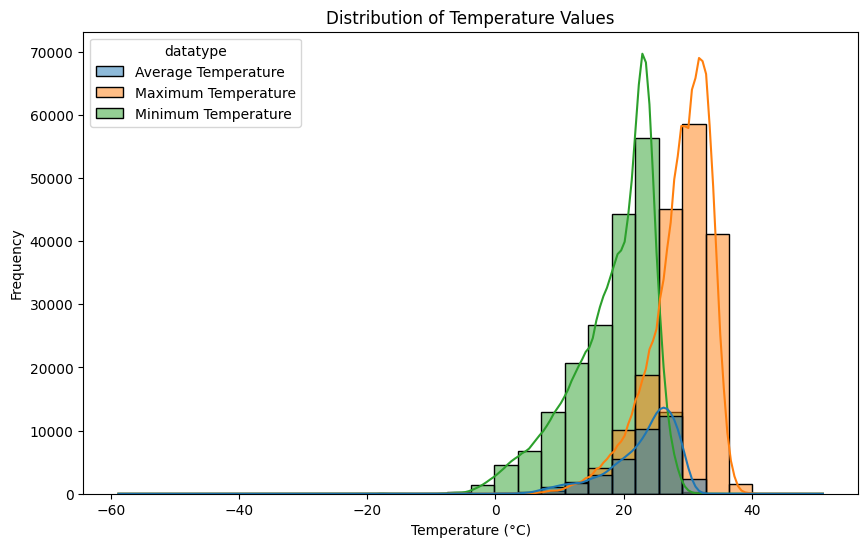

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

temp_data = df[df['datatype'].isin(['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'])]

plt.figure(figsize=(10, 6))
sns.histplot(data=temp_data, x='value', hue='datatype', bins=30, kde=True)
plt.title('Distribution of Temperature Values')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()


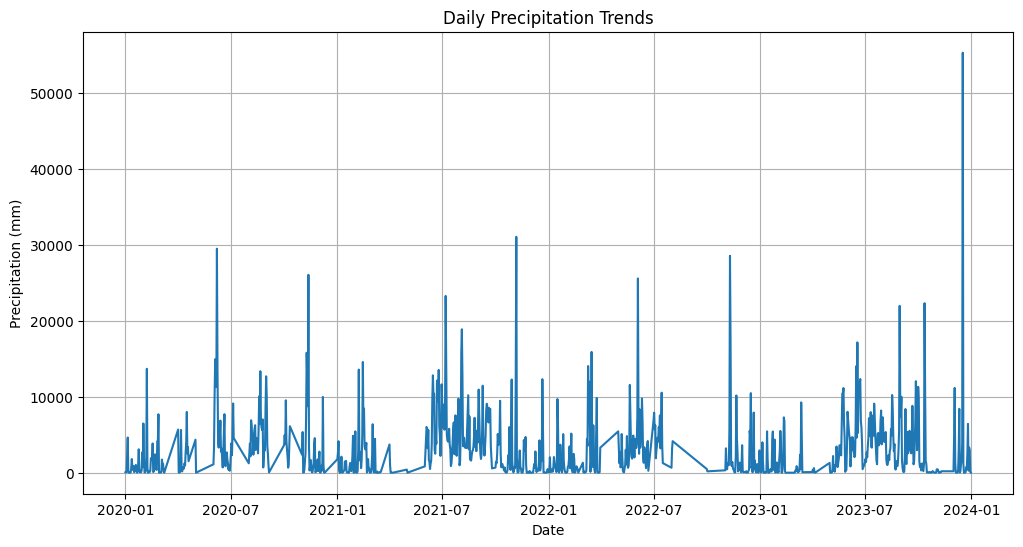

In [6]:
precip_data = df[df['datatype'] == 'Precipitation']

daily_precip = precip_data.groupby('date')['value'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(daily_precip['date'], daily_precip['value'])
plt.title('Daily Precipitation Trends')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.grid()
plt.show()


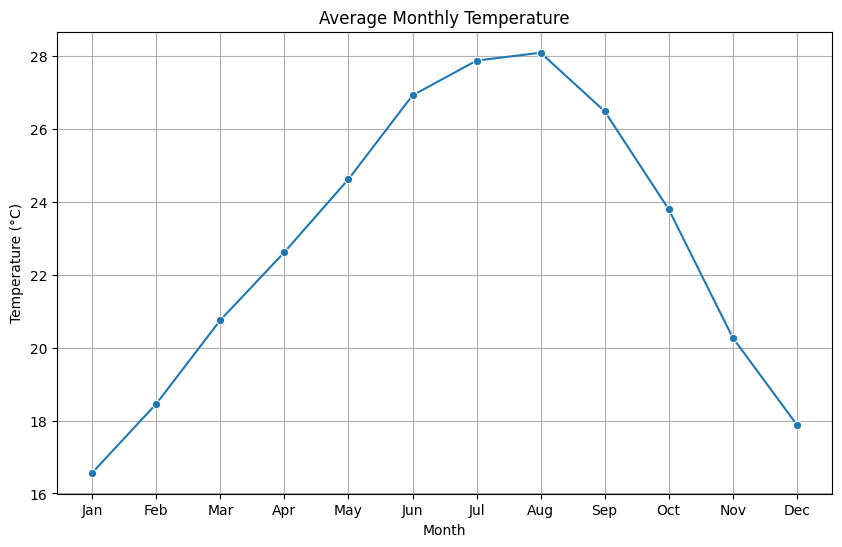

In [8]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

monthly_avg_temp = df[df['datatype'] == 'Average Temperature'].groupby('month')['value'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_avg_temp, x='month', y='value', marker='o')
plt.title('Average Monthly Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


<ipython-input-10-a6f7b428665e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thunder_data['date'] = pd.to_datetime(thunder_data['date'])
<ipython-input-10-a6f7b428665e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thunder_data['year'] = thunder_data['date'].dt.year
<ipython-input-10-a6f7b428665e>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(dat

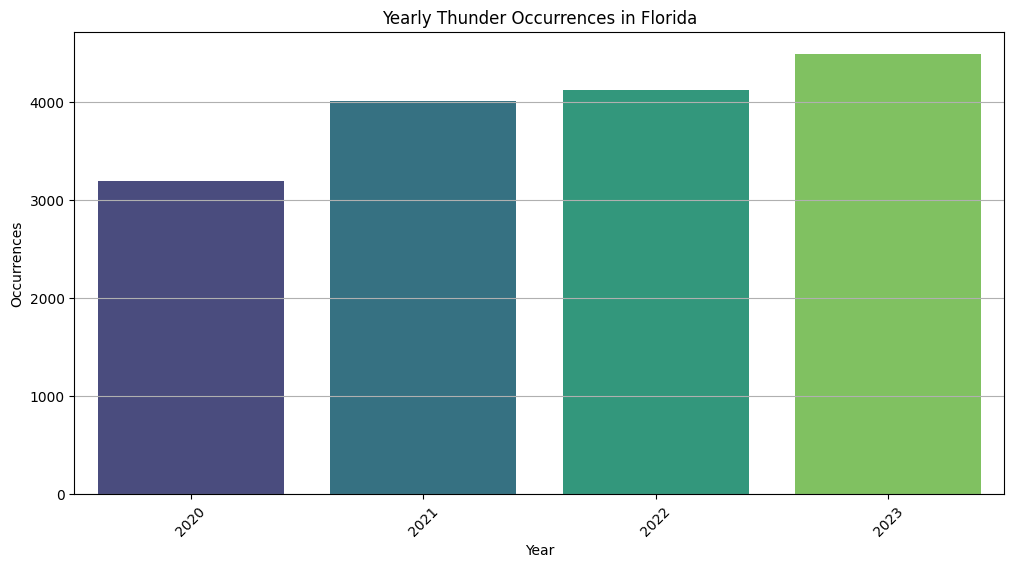

Yearly Thunder Occurrences:
   year  occurrences
0  2020         3198
1  2021         4010
2  2022         4125
3  2023         4493


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "florida_weather_data.csv"
df = pd.read_csv(file_path)

thunder_data = df[df['datatype'] == 'Thunder']

thunder_data['date'] = pd.to_datetime(thunder_data['date'])

thunder_data['year'] = thunder_data['date'].dt.year
thunder_yearly = thunder_data.groupby('year').size().reset_index(name='occurrences')

plt.figure(figsize=(12, 6))
sns.barplot(data=thunder_yearly, x='year', y='occurrences', palette='viridis')
plt.title('Yearly Thunder Occurrences in Florida')
plt.xlabel('Year')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

print("Yearly Thunder Occurrences:")
print(thunder_yearly)


In [11]:
import pandas as pd
import plotly.express as px

# Load the Florida weather dataset
df = pd.read_csv("florida_weather_data.csv")
df['date'] = pd.to_datetime(df['date'])

# Filter temperature-related datatypes
temperature_data = df[df['datatype'].isin(['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'])]
temperature_data['value'] = temperature_data['value'] / 10.0  # Convert tenths of °C to °C

# Group by month and calculate average temperature
temperature_data['month'] = temperature_data['date'].dt.to_period('M')
monthly_avg = temperature_data.groupby(['datatype', 'month'])['value'].mean().reset_index()
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()

# Create an interactive line plot with Plotly
fig = px.line(
    monthly_avg,
    x='month',
    y='value',
    color='datatype',
    labels={'value': 'Temperature (°C)', 'month': 'Date', 'datatype': 'Temperature Type'},
    title='Temperature Trends Over Time',
    markers=True
)
fig.update_traces(mode='lines+markers')
fig.update_layout(legend_title_text='Temperature Type', xaxis_title='Date', yaxis_title='Temperature (°C)')
fig.show()


<ipython-input-11-c90ce97d0a91>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['value'] = temperature_data['value'] / 10.0  # Convert tenths of °C to °C
<ipython-input-11-c90ce97d0a91>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_data['month'] = temperature_data['date'].dt.to_period('M')


<ipython-input-12-b3106d4713a2>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-b3106d4713a2>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-b3106d4713a2>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




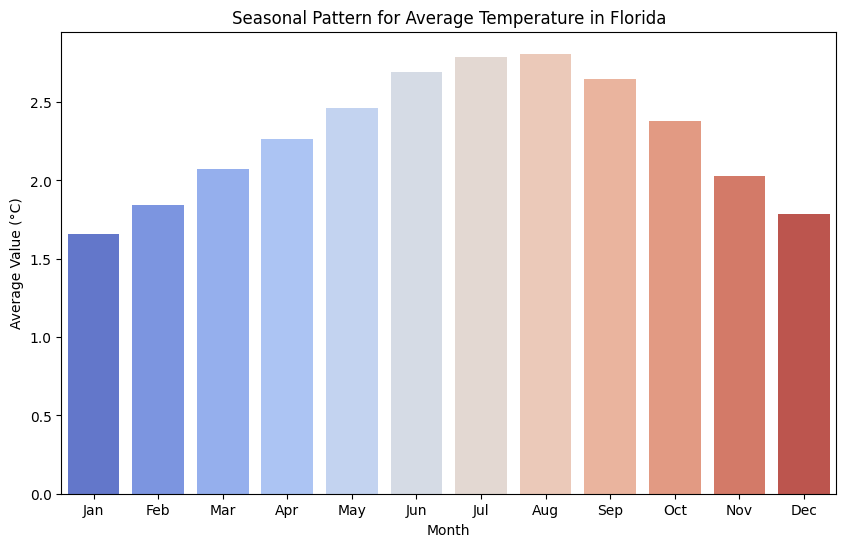

<ipython-input-12-b3106d4713a2>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




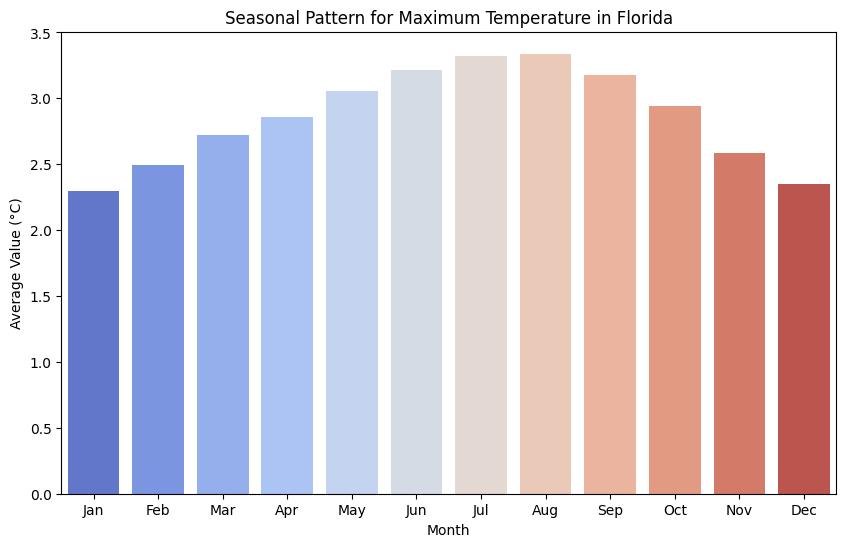

<ipython-input-12-b3106d4713a2>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




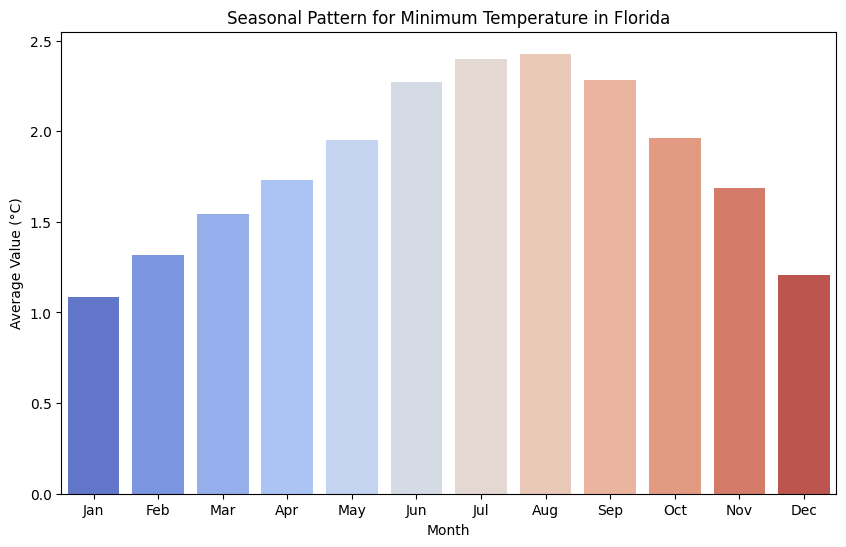

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("florida_weather_data.csv")
df['date'] = pd.to_datetime(df['date'])

temperature_data = df[df['datatype'].isin(['Average Temperature', 'Maximum Temperature', 'Minimum Temperature'])]
temperature_data['value'] = temperature_data['value'] / 10.0  # Convert tenths of °C to °C

temperature_data['month_only'] = temperature_data['date'].dt.month

monthly_avg = temperature_data.groupby(['datatype', 'month_only'])['value'].mean().reset_index()

for datatype in ['Average Temperature', 'Maximum Temperature', 'Minimum Temperature']:
    seasonal_data = monthly_avg[monthly_avg['datatype'] == datatype]
    plt.figure(figsize=(10, 6))
    sns.barplot(data=seasonal_data, x='month_only', y='value', palette='coolwarm')
    plt.title(f"Seasonal Pattern for {datatype} in Florida")
    plt.xlabel("Month")
    plt.ylabel("Average Value (°C)")
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()


**MICHIGAN ENERGY SALES**

In [13]:
import requests
import pandas as pd

api_url = "https://api.eia.gov/v2/electricity/retail-sales/data/"
api_key = "cdlbDRfbbs94lFuYuXXHYKhRQiUFLdH9vid0CaJN"

params = {
    "frequency": "monthly",
    "data[0]": "customers",
    "data[1]": "price",
    "data[2]": "sales",
    "facets[stateid][]": "MI",
    "start": "2020-01",
    "end": "2024-12",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000,
    "api_key": api_key,
}

response = requests.get(api_url, params=params)

if response.status_code == 200:
    data = response.json().get("response", {}).get("data", [])
    if data:
        df = pd.DataFrame(data)

        df.to_csv("michigan_retail_sales_2020_2024.csv", index=False)
        print("Data successfully fetched and saved to 'michigan_retail_sales_2020_2024.csv'.")
    else:
        print("No data found in the API response.")
else:
    print(f"Error {response.status_code}: {response.text}")


Data successfully fetched and saved to 'michigan_retail_sales_2020_2024.csv'.


First few rows of the dataset:
    period stateid stateDescription sectorid      sectorName  customers  \
0  2024-09      MI         Michigan      IND      industrial     5672.0   
1  2024-09      MI         Michigan      OTH           other        NaN   
2  2024-09      MI         Michigan      RES     residential  4539576.0   
3  2024-09      MI         Michigan      ALL     all sectors  5110976.0   
4  2024-09      MI         Michigan      TRA  transportation        2.0   

   price       sales  
0   8.33  2320.47808  
1    NaN         NaN  
2  20.00  2664.42985  
3  14.29  8201.88008  
4  14.49     0.49807  

Columns in the dataset:
 Index(['period', 'stateid', 'stateDescription', 'sectorid', 'sectorName',
       'customers', 'price', 'sales'],
      dtype='object')

Missing values:
 period              0
stateid             0
stateDescription    0
sectorid            0
sectorName          0
customers           0
price               0
sales               0
dtype: int64

Dataset cle

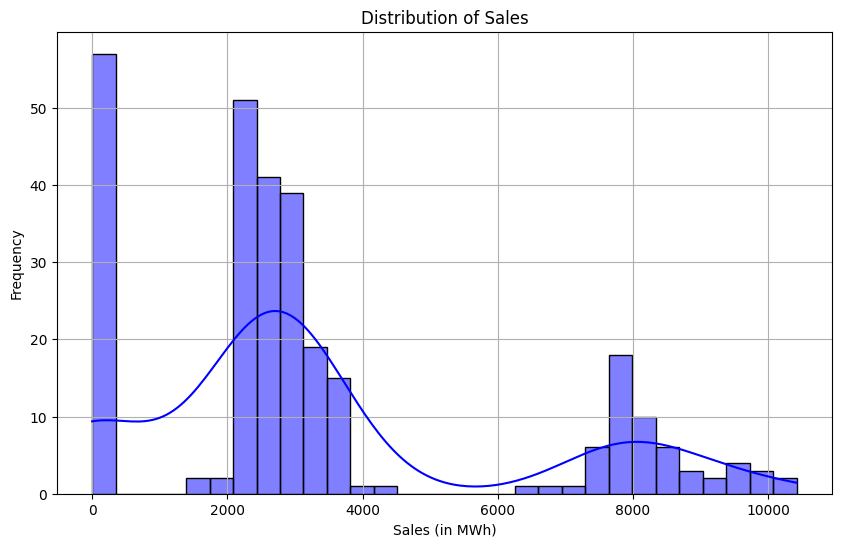


Average price by sector:
       sectorName      price
0     all sectors  13.181228
1      commercial  12.737193
2      industrial   7.930702
3     residential  17.879298
4  transportation  12.761228


<ipython-input-14-705e9046fbe8>:61: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




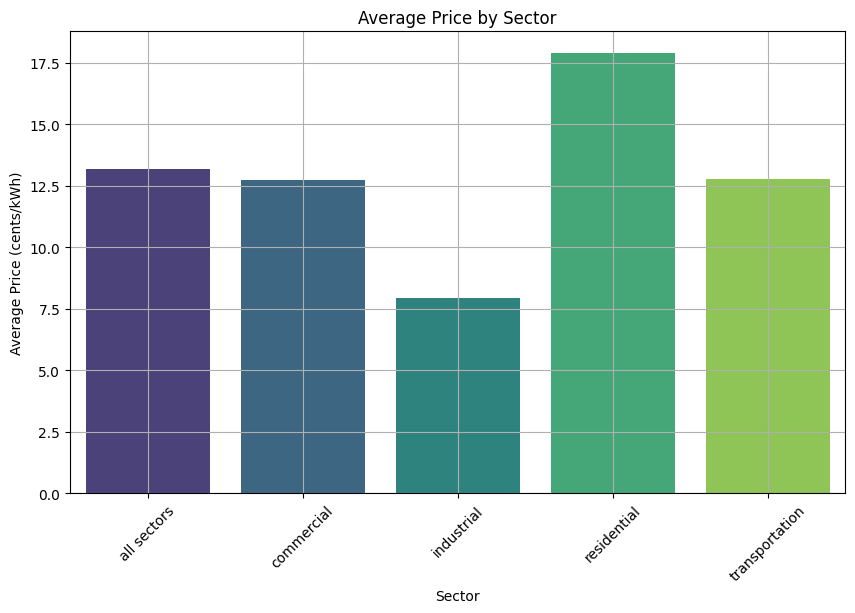

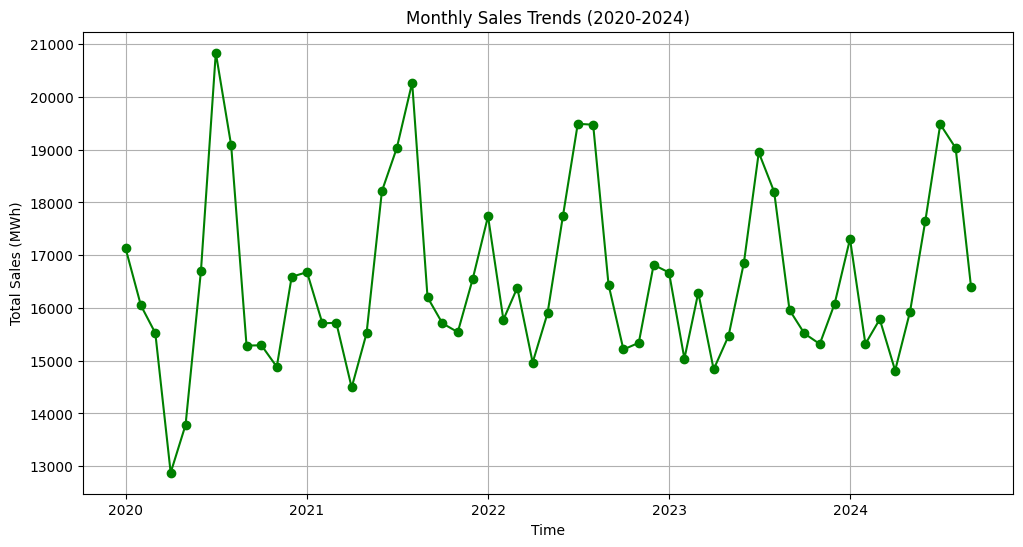


Sector-wise sales contribution (%):
       sectorName         sales  percentage
0     all sectors  470916.61946   50.000000
1      commercial  174668.23540   18.545559
2      industrial  130998.97516   13.908935
3     residential  165227.83958   17.543216
4  transportation      21.56937    0.002290


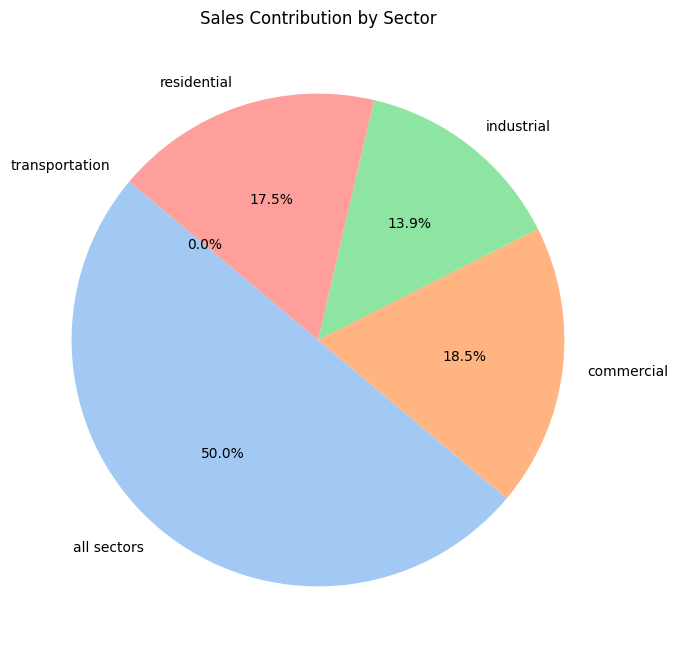

In [14]:
import pandas as pd

df = pd.read_csv("michigan_retail_sales_2020_2024.csv")

df = df.drop(columns=["customers-units", "price-units", "sales-units"], errors="ignore")

print("First few rows of the dataset:")
print(df.head())

print("\nColumns in the dataset:\n", df.columns)

df = df.dropna()

df = df[~df.isin(["None"]).any(axis=1)]

print("\nMissing values:\n", df.isnull().sum())
print("\nDataset cleaned of 'None' entries.")

cleaned_file = "cleaned_energy_data_MI.csv"
df.to_csv(cleaned_file, index=False)
print(f"Cleaned dataset saved as '{cleaned_file}'.")

print("\nSummary Statistics for numeric columns:")
print(df.describe())

categorical_columns = df.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    print(f"\nUnique values in '{col}':", df[col].unique())

# 1. Distribution of sales values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df["sales"], bins=30, kde=True, color="blue")
plt.title("Distribution of Sales")
plt.xlabel("Sales (in MWh)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# 2. Average price per sector
if "sectorName" in df.columns and "price" in df.columns:
    avg_price_sector = df.groupby("sectorName")["price"].mean().reset_index()
    print("\nAverage price by sector:")
    print(avg_price_sector)

    # Bar plot for average price per sector
    plt.figure(figsize=(10, 6))
    sns.barplot(data=avg_price_sector, x="sectorName", y="price", palette="viridis")
    plt.title("Average Price by Sector")
    plt.xlabel("Sector")
    plt.ylabel("Average Price (cents/kWh)")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# 3. Trends over time
if "period" in df.columns:
    df["period"] = pd.to_datetime(df["period"])
    monthly_sales = df.groupby("period")["sales"].sum().reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(monthly_sales["period"], monthly_sales["sales"], marker="o", color="green")
    plt.title("Monthly Sales Trends (2020-2024)")
    plt.xlabel("Time")
    plt.ylabel("Total Sales (MWh)")
    plt.grid()
    plt.show()

# 4. Sector-wise sales contribution
if "sectorName" in df.columns and "sales" in df.columns:
    sales_by_sector = df.groupby("sectorName")["sales"].sum().reset_index()
    sales_by_sector["percentage"] = (sales_by_sector["sales"] / sales_by_sector["sales"].sum()) * 100
    print("\nSector-wise sales contribution (%):")
    print(sales_by_sector)

    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(
        sales_by_sector["sales"],
        labels=sales_by_sector["sectorName"],
        autopct="%1.1f%%",
        startangle=140,
        colors=sns.color_palette("pastel"),
    )
    plt.title("Sales Contribution by Sector")
    plt.show()


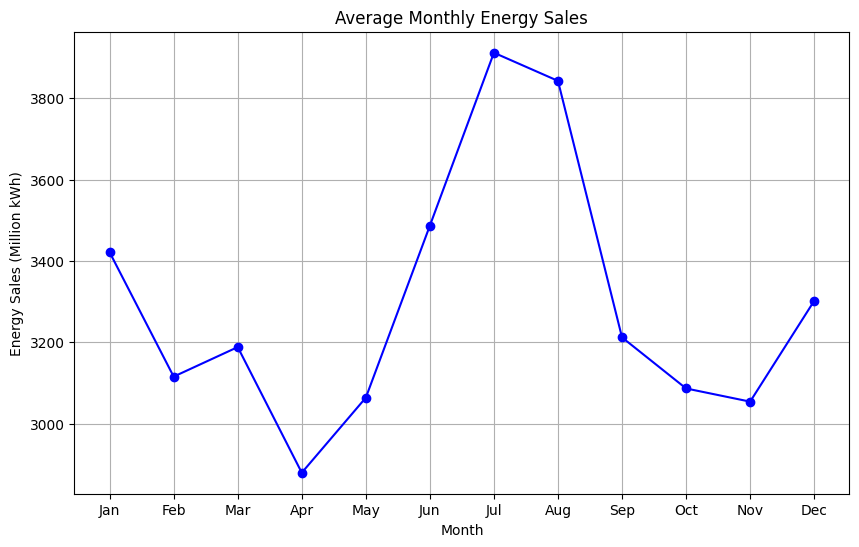

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_energy_data_MI.csv")

df["period"] = pd.to_datetime(df["period"])

df["month"] = df["period"].dt.month

monthly_sales = df.groupby("month")["sales"].mean()

plt.figure(figsize=(10, 6))
monthly_sales.plot(kind="line", marker="o", color="blue")
plt.title("Average Monthly Energy Sales")
plt.xlabel("Month")
plt.ylabel("Energy Sales (Million kWh)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


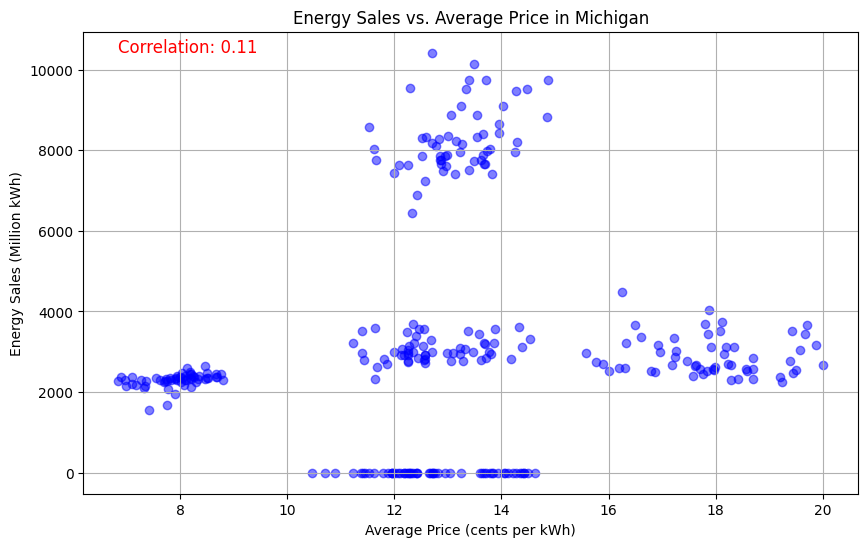

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_energy_data_MI.csv")

df["sales"] = pd.to_numeric(df["sales"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")

df = df.dropna(subset=["sales", "price"])

correlation = df["sales"].corr(df["price"])

plt.figure(figsize=(10, 6))
plt.scatter(df["price"], df["sales"], alpha=0.5, color="blue")
plt.title("Energy Sales vs. Average Price in Michigan")
plt.xlabel("Average Price (cents per kWh)")
plt.ylabel("Energy Sales (Million kWh)")
plt.grid(True)

plt.text(min(df["price"]), max(df["sales"]), f"Correlation: {correlation:.2f}", fontsize=12, color="red")

plt.show()


In [16]:
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
import pandas as pd

energy_data = pd.read_csv("cleaned_energy_data_MI.csv")

sector_sales = energy_data.groupby("sectorName")["sales"].sum().reset_index()

source = ColumnDataSource(data=sector_sales)

p = figure(x_range=sector_sales["sectorName"],
           title="Total Energy Sales by Sector in Michigan",
           toolbar_location=None, tools="")

p.vbar(x="sectorName", top="sales", width=0.9, source=source, legend_field="sectorName", color="navy")

hover = HoverTool()
hover.tooltips = [("Sector", "@sectorName"), ("Sales", "@sales{0,0}")]
p.add_tools(hover)

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.axis_label = "Sector"
p.yaxis.axis_label = "Total Energy Sales (MWh)"
p.xaxis.major_label_orientation = 1.0  # Rotate x-axis labels for better readability
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

output_file("energy_sales_bokeh.html")
show(p)


Periods with significant disruptions in energy sales (Michigan):
         period stateid stateDescription sectorid      sectorName  customers  \
6   2024-08-01      MI         Michigan      RES     residential  4536340.0   
22  2024-05-01      MI         Michigan      RES     residential  4531699.0   
43  2024-01-01      MI         Michigan      RES     residential  4526293.0   
52  2023-11-01      MI         Michigan      TRA  transportation        2.0   
56  2023-10-01      MI         Michigan      TRA  transportation        2.0   
66  2023-08-01      MI         Michigan      RES     residential  4497032.0   
77  2023-06-01      MI         Michigan      RES     residential  4493909.0   
86  2023-04-01      MI         Michigan      TRA  transportation        2.0   
113 2022-11-01      MI         Michigan      TRA  transportation        2.0   
116 2022-10-01      MI         Michigan      TRA  transportation        2.0   
123 2022-09-01      MI         Michigan      TRA  transportation 

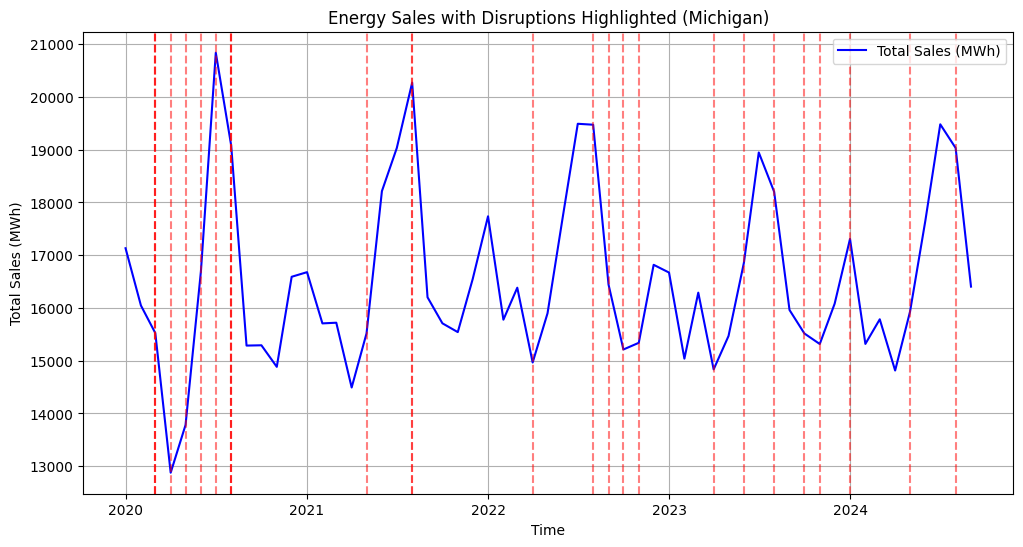

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_energy_data_MI.csv")

df["sales"] = pd.to_numeric(df["sales"], errors="coerce")

df = df.dropna(subset=["sales"])

df["period"] = pd.to_datetime(df["period"])

df["sales_change"] = df.groupby("sectorName")["sales"].pct_change() * 100

threshold = 20
disruptions = df[df["sales_change"].abs() > threshold]

print("Periods with significant disruptions in energy sales (Michigan):\n", disruptions)

sales_trends = df.groupby("period")["sales"].sum()

plt.figure(figsize=(12, 6))
plt.plot(sales_trends, label="Total Sales (MWh)", color="blue")

for period in disruptions["period"]:
    plt.axvline(x=period, color="red", linestyle="--", alpha=0.5)

plt.title("Energy Sales with Disruptions Highlighted (Michigan)")
plt.xlabel("Time")
plt.ylabel("Total Sales (MWh)")
plt.legend()
plt.grid()
plt.show()


Merged data shape: (48, 13)
       period stateid stateDescription sectorid   sectorName  customers  \
0  2023-12-01      MI         Michigan      ALL  all sectors  5071884.0   
10 2023-11-01      MI         Michigan      ALL  all sectors  5068005.0   
12 2023-10-01      MI         Michigan      ALL  all sectors  5071837.0   
18 2023-09-01      MI         Michigan      ALL  all sectors  5061919.0   
28 2023-08-01      MI         Michigan      ALL  all sectors  5063199.0   

    price       sales      customers-units              price-units  \
0   13.78  8039.68803  number of customers  cents per kilowatt-hour   
10  13.70  7657.78079  number of customers  cents per kilowatt-hour   
12  13.62  7757.67984  number of customers  cents per kilowatt-hour   
18  13.73  7980.24996  number of customers  cents per kilowatt-hour   
28  14.03  9101.15422  number of customers  cents per kilowatt-hour   

               sales-units year_month  total_wind_events  
0   million kilowatt hours    2023-

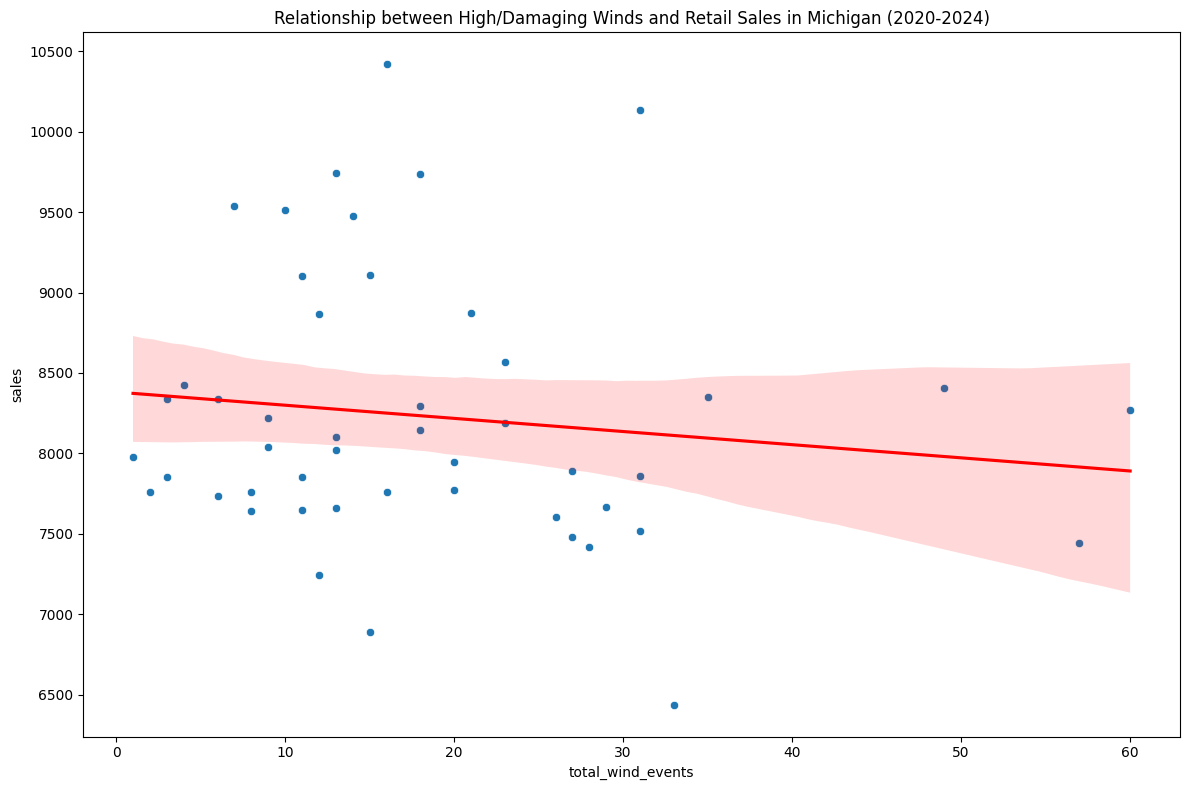

Correlation coefficient between wind events and sales: -0.13


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sales_data = pd.read_csv("michigan_retail_sales_2020_2024.csv")

weather_data = pd.read_csv("michigan_weather_data.csv")

sales_data["period"] = pd.to_datetime(sales_data["period"])
weather_data["date"] = pd.to_datetime(weather_data["date"])

sales_data["year_month"] = sales_data["period"].dt.to_period("M")
weather_data["year_month"] = weather_data["date"].dt.to_period("M")

wind_data = weather_data[weather_data["datatype"] == "High or damaging winds"].groupby("year_month")["value"].sum().reset_index()
wind_data.columns = ["year_month", "total_wind_events"]

merged_data = pd.merge(sales_data, wind_data, on="year_month", how="inner")

merged_data = merged_data[merged_data["sectorid"] == "ALL"]

print("Merged data shape:", merged_data.shape)
print(merged_data.head())

plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_data, x="total_wind_events", y="sales")
plt.title("Relationship between High/Damaging Winds and Retail Sales in Michigan (2020-2024)")
plt.xlabel("Total Monthly High or Damaging Wind Events")
plt.ylabel("Monthly Retail Sales (million kilowatt hours)")

sns.regplot(data=merged_data, x="total_wind_events", y="sales", scatter=False, color="red")

plt.tight_layout()
plt.show()

correlation = merged_data["total_wind_events"].corr(merged_data["sales"])
print(f"Correlation coefficient between wind events and sales: {correlation:.2f}")




Merged data shape: (48, 13)
       period stateid stateDescription sectorid   sectorName  customers  \
0  2023-12-01      MI         Michigan      ALL  all sectors  5071884.0   
10 2023-11-01      MI         Michigan      ALL  all sectors  5068005.0   
12 2023-10-01      MI         Michigan      ALL  all sectors  5071837.0   
18 2023-09-01      MI         Michigan      ALL  all sectors  5061919.0   
28 2023-08-01      MI         Michigan      ALL  all sectors  5063199.0   

    price       sales      customers-units              price-units  \
0   13.78  8039.68803  number of customers  cents per kilowatt-hour   
10  13.70  7657.78079  number of customers  cents per kilowatt-hour   
12  13.62  7757.67984  number of customers  cents per kilowatt-hour   
18  13.73  7980.24996  number of customers  cents per kilowatt-hour   
28  14.03  9101.15422  number of customers  cents per kilowatt-hour   

               sales-units year_month  total_precipitation  
0   million kilowatt hours    202

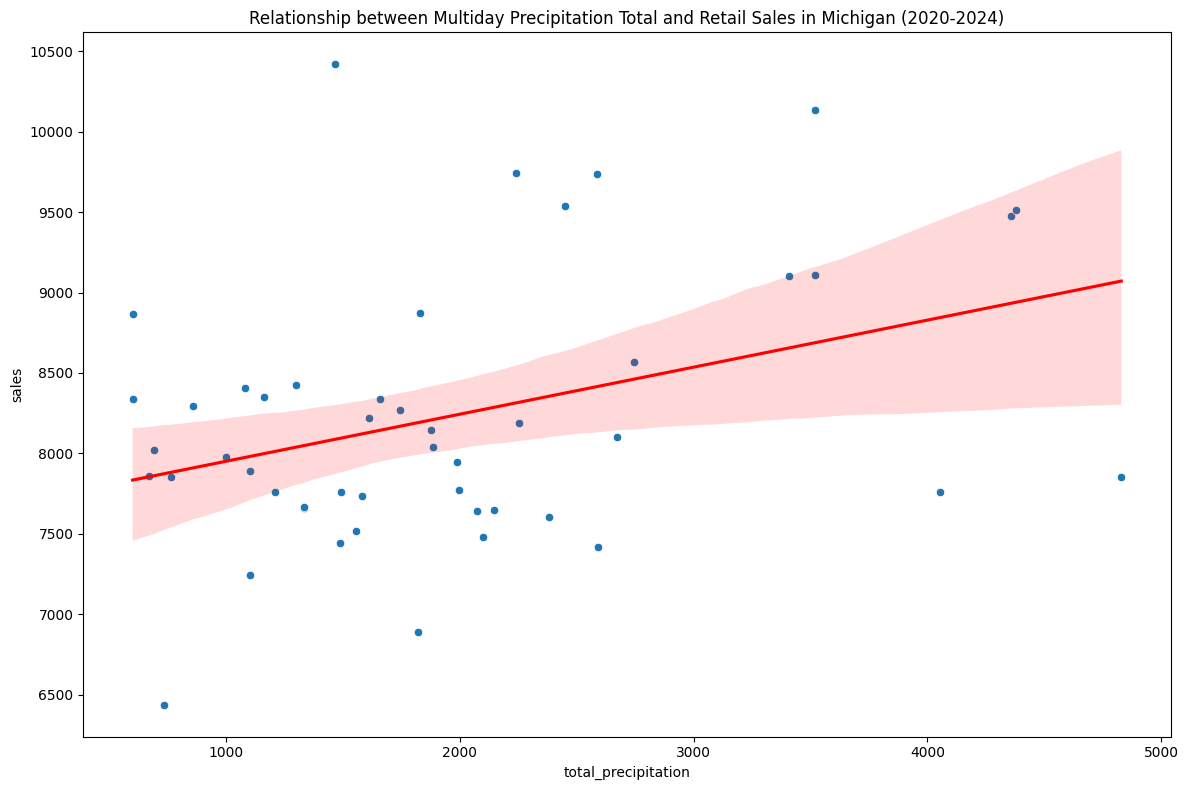

Correlation coefficient between precipitation and sales: 0.37


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Michigan retail sales dataset
sales_data = pd.read_csv("michigan_retail_sales_2020_2024.csv")

# Load the Michigan weather data
weather_data = pd.read_csv("michigan_weather_data.csv")

# Ensure date columns are in datetime format for both datasets
sales_data["period"] = pd.to_datetime(sales_data["period"])
weather_data["date"] = pd.to_datetime(weather_data["date"])

# Create year_month column for both datasets
sales_data["year_month"] = sales_data["period"].dt.to_period("M")
weather_data["year_month"] = weather_data["date"].dt.to_period("M")

# Filter and aggregate weather data for multiday precipitation total
precipitation_data = weather_data[weather_data["datatype"] == "Multiday precipitation total"].groupby("year_month")["value"].sum().reset_index()
precipitation_data.columns = ["year_month", "total_precipitation"]

# Merge the datasets on 'year_month'
merged_data = pd.merge(sales_data, precipitation_data, on="year_month", how="inner")

# Filter for 'ALL' sector (total sales across all sectors)
merged_data = merged_data[merged_data["sectorid"] == "ALL"]

print("Merged data shape:", merged_data.shape)
print(merged_data.head())

# Create a scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_data, x="total_precipitation", y="sales")
plt.title("Relationship between Multiday Precipitation Total and Retail Sales in Michigan (2020-2024)")
plt.xlabel("Total Monthly Precipitation")
plt.ylabel("Monthly Retail Sales (million kilowatt hours)")

# Add a trend line
sns.regplot(data=merged_data, x="total_precipitation", y="sales", scatter=False, color="red")

plt.tight_layout()
plt.show()

# Print correlation coefficient
correlation = merged_data["total_precipitation"].corr(merged_data["sales"])
print(f"Correlation coefficient between precipitation and sales: {correlation:.2f}")


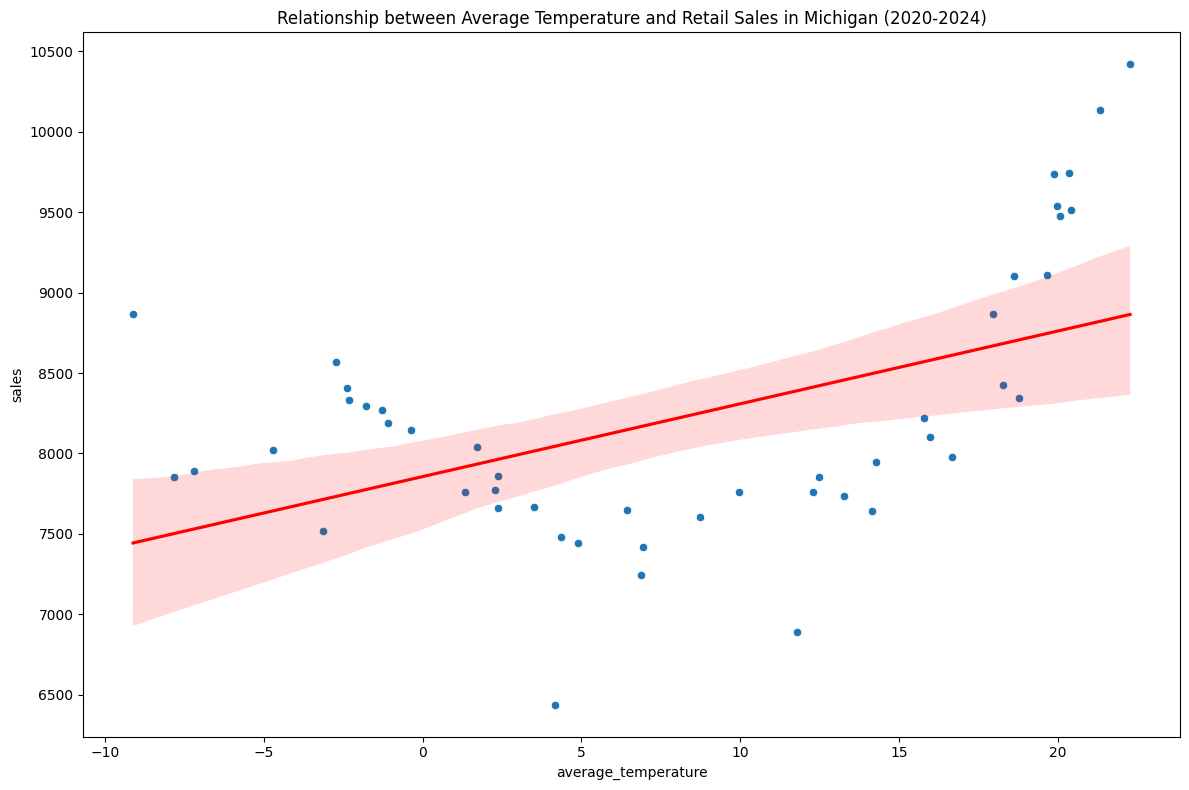

Correlation coefficient between average temperature and sales: 0.50


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Michigan retail sales dataset
sales_data = pd.read_csv("michigan_retail_sales_2020_2024.csv")

# Load the Michigan weather data
weather_data = pd.read_csv("michigan_weather_data.csv")

# Ensure date columns are in datetime format for both datasets
sales_data["period"] = pd.to_datetime(sales_data["period"])
weather_data["date"] = pd.to_datetime(weather_data["date"])

# Create year_month column for both datasets
sales_data["year_month"] = sales_data["period"].dt.to_period("M")
weather_data["year_month"] = weather_data["date"].dt.to_period("M")

# Filter and aggregate weather data for average temperature
temperature_data = weather_data[weather_data["datatype"] == "Average Temperature"].groupby("year_month")["value"].mean().reset_index()
temperature_data.columns = ["year_month", "average_temperature"]

# Merge the datasets on 'year_month'
merged_data = pd.merge(sales_data, temperature_data, on="year_month", how="inner")

# Filter for 'ALL' sector (total sales across all sectors)
merged_data = merged_data[merged_data["sectorid"] == "ALL"]

# Create a scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_data, x="average_temperature", y="sales")
plt.title("Relationship between Average Temperature and Retail Sales in Michigan (2020-2024)")
plt.xlabel("Average Monthly Temperature")
plt.ylabel("Monthly Retail Sales (million kilowatt hours)")

# Add a trend line
sns.regplot(data=merged_data, x="average_temperature", y="sales", scatter=False, color="red")

plt.tight_layout()
plt.show()

# Print correlation coefficient
correlation = merged_data["average_temperature"].corr(merged_data["sales"])
print(f"Correlation coefficient between average temperature and sales: {correlation:.2f}")


**FLORIDA ENERGY SALES**

In [26]:
import requests
import pandas as pd

api_url = "https://api.eia.gov/v2/electricity/retail-sales/data/"
api_key = "cdlbDRfbbs94lFuYuXXHYKhRQiUFLdH9vid0CaJN"

params = {
    "frequency": "monthly",
    "data[0]": "customers",
    "data[1]": "price",
    "data[2]": "sales",
    "facets[stateid][]": "FL",
    "start": "2020-01",
    "end": "2023-12",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000,
    "api_key": api_key,
}

response = requests.get(api_url, params=params)

if response.status_code == 200:
    data = response.json().get("response", {}).get("data", [])
    if data:
        df = pd.DataFrame(data)

        df.to_csv("florida_retail_sales.csv", index=False)
        print("Data successfully fetched and saved to 'florida_retail_sales.csv'.")
    else:
        print("No data found in the API response.")
else:
    print(f"Error {response.status_code}: {response.text}")


Data successfully fetched and saved to 'florida_retail_sales.csv'.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df_florida = pd.read_csv("florida_retail_sales.csv")

# Step 1: Inspect the dataset
print("Initial dataset shape:", df_florida.shape)
print("Columns in the dataset:\n", df_florida.columns)

# Step 2: Drop unnecessary columns if they exist
columns_to_drop = ["customers-units", "price-units", "sales-units"]  # Adjust based on actual columns
df_florida = df_florida.drop(columns=[col for col in columns_to_drop if col in df_florida.columns], errors="ignore")

# Step 3: Check for missing values
missing_values = df_florida.isnull().sum()
print("\nMissing values in the dataset:\n", missing_values)

# Step 4: Drop rows with missing values in critical columns ('sales', 'price', etc.)
df_florida = df_florida.dropna(subset=["sales", "price"])

# Step 5: Ensure numeric data types for 'sales' and 'price'
df_florida["sales"] = pd.to_numeric(df_florida["sales"], errors="coerce")
df_florida["price"] = pd.to_numeric(df_florida["price"], errors="coerce")

# Step 6: Drop any remaining rows with invalid data
df_florida = df_florida.dropna(subset=["sales", "price"])

# Step 7: Save the cleaned dataset
df_florida.to_csv("cleaned_florida_retail_sales.csv", index=False)
print("\nCleaned dataset saved as 'cleaned_florida_retail_sales.csv'.")


Initial dataset shape: (288, 11)
Columns in the dataset:
 Index(['period', 'stateid', 'stateDescription', 'sectorid', 'sectorName',
       'customers', 'price', 'sales', 'customers-units', 'price-units',
       'sales-units'],
      dtype='object')

Missing values in the dataset:
 period               0
stateid              0
stateDescription     0
sectorid             0
sectorName           0
customers           48
price               48
sales               48
dtype: int64

Cleaned dataset saved as 'cleaned_florida_retail_sales.csv'.


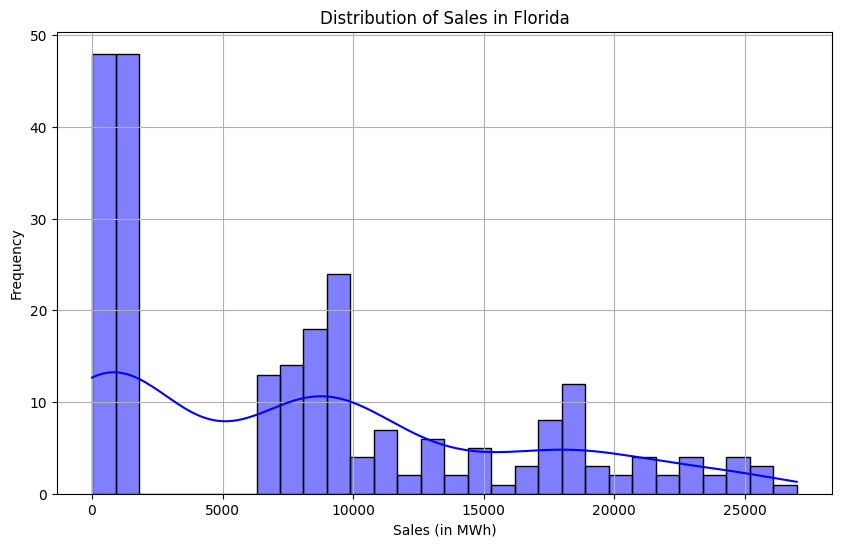


Average price by sector:
       sectorName      price
0     all sectors  11.686875
1      commercial  10.383125
2      industrial   8.336875
3     residential  13.069375
4  transportation   9.385417


<ipython-input-29-9768b878b152>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




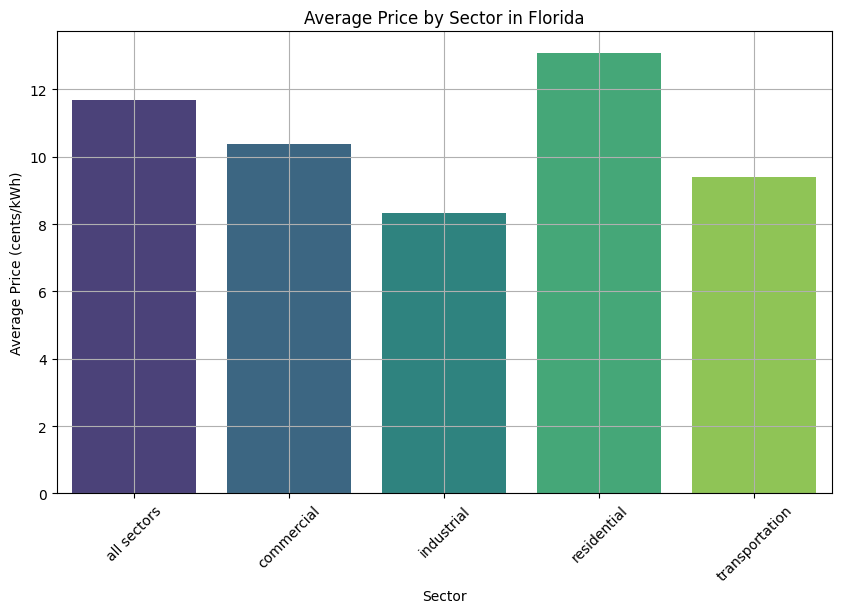

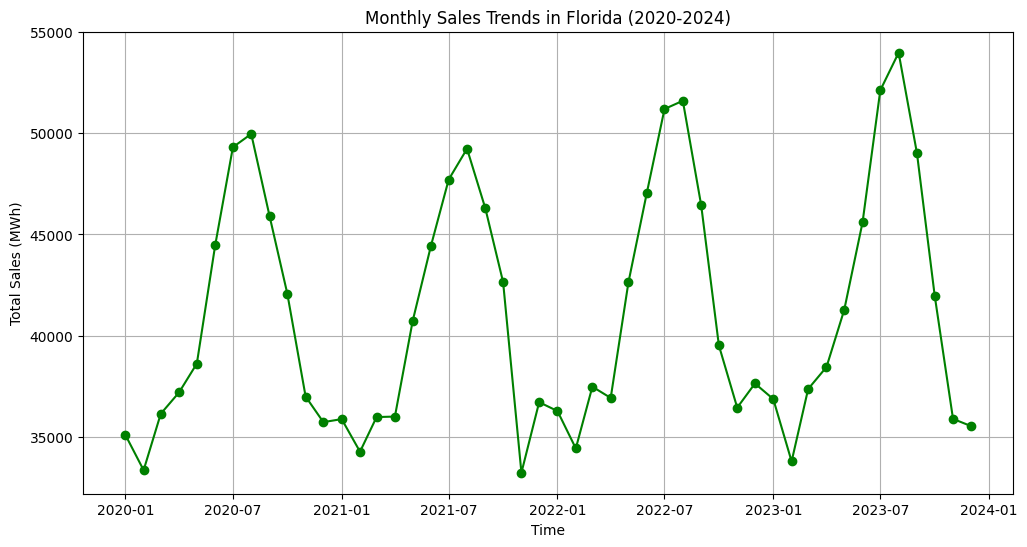


Sector-wise sales contribution (%):
       sectorName         sales  percentage
0     all sectors  983763.26999   50.000000
1      commercial  380578.32303   19.342983
2      industrial   69129.81707    3.513539
3     residential  533762.32999   27.128596
4  transportation     292.80002    0.014882


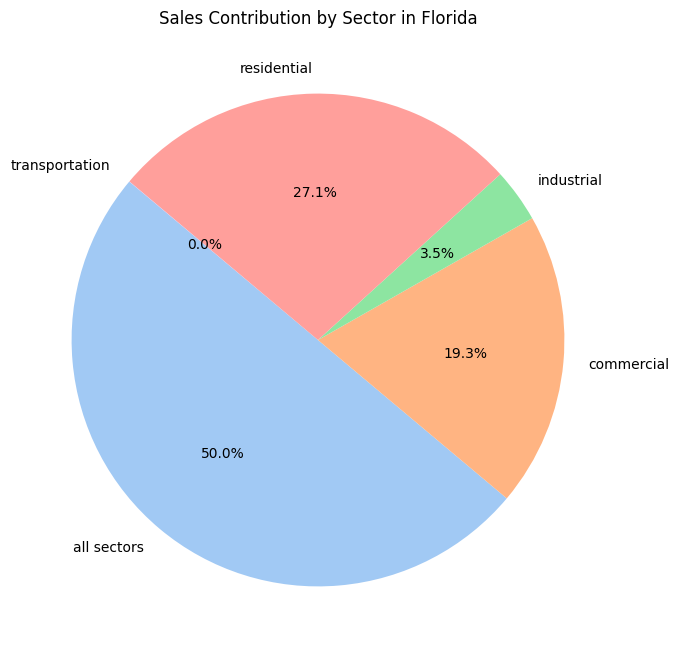

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv("cleaned_florida_retail_sales.csv")

# 1. Distribution of Sales Values
plt.figure(figsize=(10, 6))
sns.histplot(df["sales"], bins=30, kde=True, color="blue")
plt.title("Distribution of Sales in Florida")
plt.xlabel("Sales (in MWh)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# 2. Average Price Per Sector
if "sectorName" in df.columns and "price" in df.columns:
    avg_price_sector = df.groupby("sectorName")["price"].mean().reset_index()
    print("\nAverage price by sector:")
    print(avg_price_sector)

    # Bar plot for average price per sector
    plt.figure(figsize=(10, 6))
    sns.barplot(data=avg_price_sector, x="sectorName", y="price", palette="viridis")
    plt.title("Average Price by Sector in Florida")
    plt.xlabel("Sector")
    plt.ylabel("Average Price (cents/kWh)")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

# 3. Monthly Sales Trends Over Time
if "period" in df.columns:
    df["period"] = pd.to_datetime(df["period"])
    monthly_sales = df.groupby("period")["sales"].sum().reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(monthly_sales["period"], monthly_sales["sales"], marker="o", color="green")
    plt.title("Monthly Sales Trends in Florida (2020-2024)")
    plt.xlabel("Time")
    plt.ylabel("Total Sales (MWh)")
    plt.grid()
    plt.show()

# 4. Sector-Wise Sales Contribution
if "sectorName" in df.columns and "sales" in df.columns:
    sales_by_sector = df.groupby("sectorName")["sales"].sum().reset_index()
    sales_by_sector["percentage"] = (sales_by_sector["sales"] / sales_by_sector["sales"].sum()) * 100
    print("\nSector-wise sales contribution (%):")
    print(sales_by_sector)

    # Pie chart for sector-wise sales
    plt.figure(figsize=(8, 8))
    plt.pie(
        sales_by_sector["sales"],
        labels=sales_by_sector["sectorName"],
        autopct="%1.1f%%",
        startangle=140,
        colors=sns.color_palette("pastel"),
    )
    plt.title("Sales Contribution by Sector in Florida")
    plt.show()


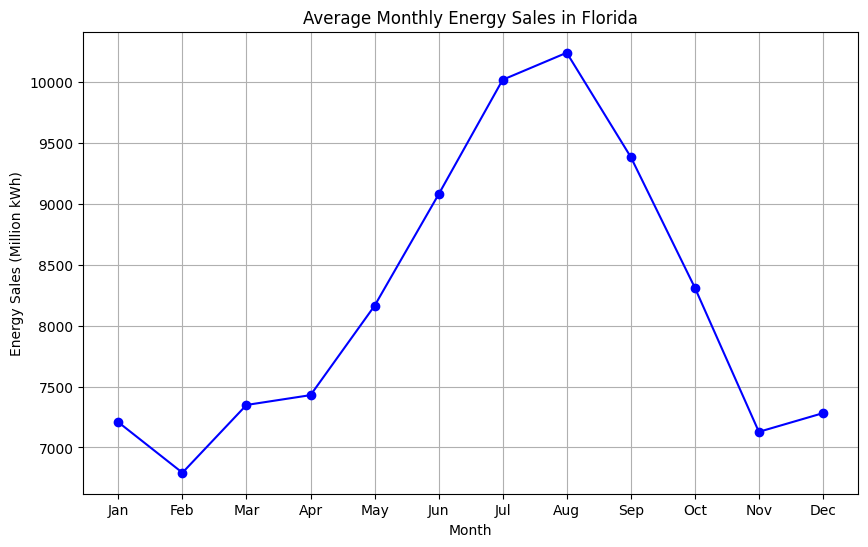

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned Florida dataset
df = pd.read_csv("cleaned_florida_retail_sales.csv")

# Ensure the period is in datetime format
df["period"] = pd.to_datetime(df["period"])

# Extract the month from the period
df["month"] = df["period"].dt.month

# Calculate the average sales per month
monthly_sales = df.groupby("month")["sales"].mean()

# Plot average monthly energy sales
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind="line", marker="o", color="blue")
plt.title("Average Monthly Energy Sales in Florida")
plt.xlabel("Month")
plt.ylabel("Energy Sales (Million kWh)")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


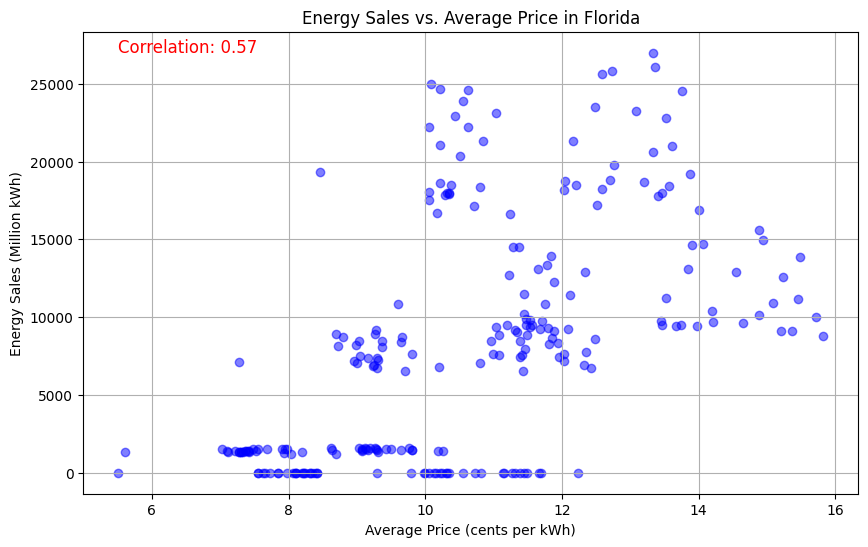

In [31]:
# Convert sales and price to numeric
df["sales"] = pd.to_numeric(df["sales"], errors="coerce")
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Drop rows with missing values in sales or price
df = df.dropna(subset=["sales", "price"])

# Calculate correlation
correlation = df["sales"].corr(df["price"])

# Scatter plot for sales vs. price
plt.figure(figsize=(10, 6))
plt.scatter(df["price"], df["sales"], alpha=0.5, color="blue")
plt.title("Energy Sales vs. Average Price in Florida")
plt.xlabel("Average Price (cents per kWh)")
plt.ylabel("Energy Sales (Million kWh)")
plt.grid(True)

# Display correlation on the plot
plt.text(min(df["price"]), max(df["sales"]), f"Correlation: {correlation:.2f}", fontsize=12, color="red")

plt.show()


Periods with significant disruptions in energy sales (Florida):
         period stateid stateDescription sectorid      sectorName   customers  \
12  2023-10-01      FL          Florida      RES     residential  10275219.0   
17  2023-09-01      FL          Florida      RES     residential  10257786.0   
77  2022-09-01      FL          Florida      RES     residential  10102243.0   
114 2022-02-01      FL          Florida      IND      industrial     22837.0   
126 2021-11-01      FL          Florida      TRA  transportation         2.0   
128 2021-11-01      FL          Florida      IND      industrial     23066.0   
130 2021-10-01      FL          Florida      IND      industrial     23147.0   
131 2021-10-01      FL          Florida      RES     residential   9989148.0   
133 2021-10-01      FL          Florida      ALL     all sectors  11290175.0   
134 2021-10-01      FL          Florida      COM      commercial   1277878.0   

     price        sales  month  sales_change  
12   15

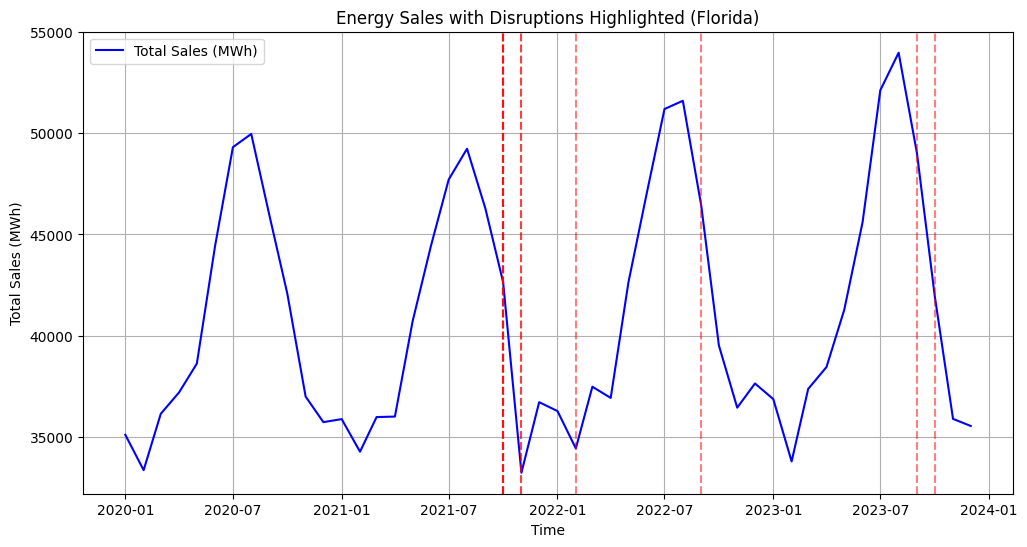

In [32]:
# Convert sales to numeric
df["sales"] = pd.to_numeric(df["sales"], errors="coerce")

# Drop rows with missing sales data
df = df.dropna(subset=["sales"])

# Ensure the period is in datetime format
df["period"] = pd.to_datetime(df["period"])

# Calculate percentage change in sales by sector
df["sales_change"] = df.groupby("sectorName")["sales"].pct_change() * 100

# Define a threshold for disruptions
threshold = 20
disruptions = df[df["sales_change"].abs() > threshold]

# Print periods with significant disruptions
print("Periods with significant disruptions in energy sales (Florida):\n", disruptions)

# Group sales trends by period
sales_trends = df.groupby("period")["sales"].sum()

# Plot sales trends with disruptions highlighted
plt.figure(figsize=(12, 6))
plt.plot(sales_trends, label="Total Sales (MWh)", color="blue")

for period in disruptions["period"]:
    plt.axvline(x=period, color="red", linestyle="--", alpha=0.5)

plt.title("Energy Sales with Disruptions Highlighted (Florida)")
plt.xlabel("Time")
plt.ylabel("Total Sales (MWh)")
plt.legend()
plt.grid()
plt.show()


In [36]:
print(weather_data.columns)


Index(['date', 'datatype', 'station', 'attributes', 'value', 'year_month'], dtype='object')


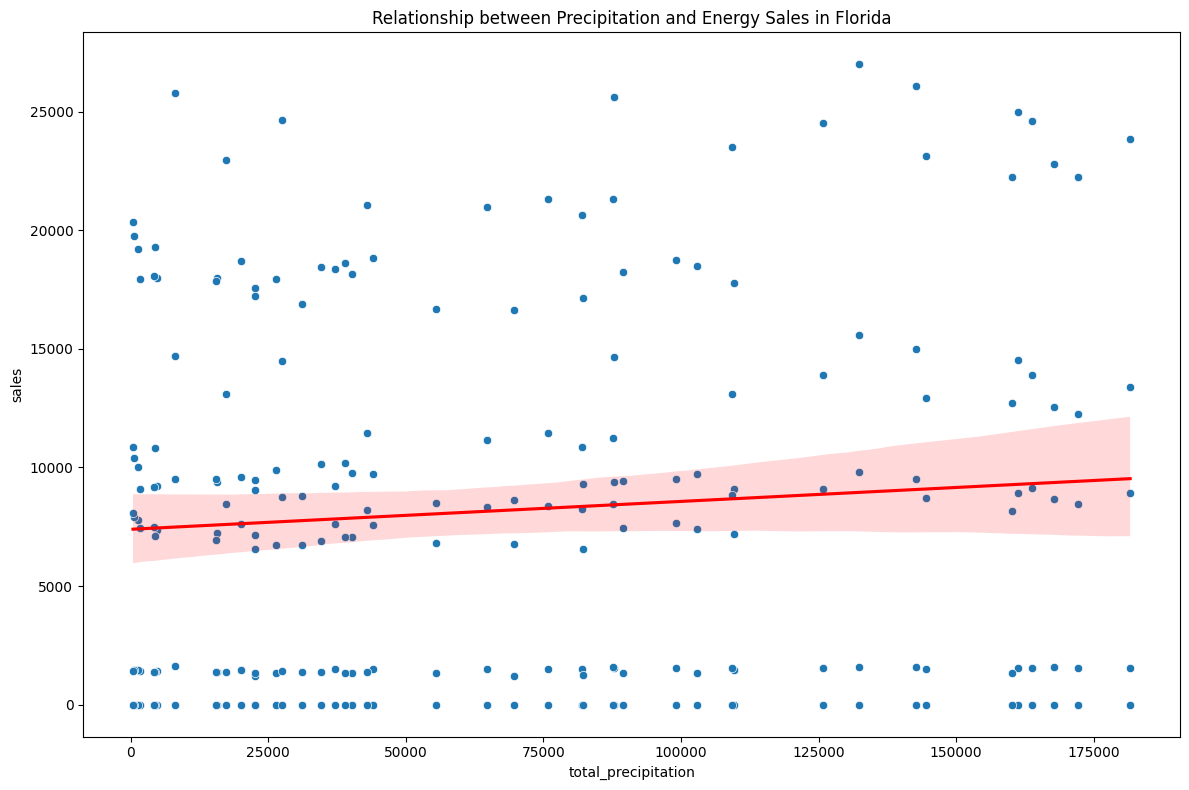

Correlation coefficient between precipitation and sales: 0.09


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

energy_data = pd.read_csv("cleaned_florida_retail_sales.csv")

weather_data = pd.read_csv("florida_weather_data.csv")

energy_data["period"] = pd.to_datetime(energy_data["period"])
weather_data["date"] = pd.to_datetime(weather_data["date"])

energy_data["year_month"] = energy_data["period"].dt.to_period("M")
weather_data["year_month"] = weather_data["date"].dt.to_period("M")

precipitation_data = weather_data[weather_data["datatype"] == "Precipitation"].groupby("year_month")["value"].sum().reset_index()
precipitation_data.columns = ["year_month", "total_precipitation"]

merged_data = pd.merge(energy_data, precipitation_data, on="year_month", how="inner")

plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_data, x="total_precipitation", y="sales")
plt.title("Relationship between Precipitation and Energy Sales in Florida")
plt.xlabel("Total Monthly Precipitation")
plt.ylabel("Monthly Energy Sales")

sns.regplot(data=merged_data, x="total_precipitation", y="sales", scatter=False, color="red")

plt.tight_layout()
plt.show()

correlation = merged_data["total_precipitation"].corr(merged_data["sales"])
print(f"Correlation coefficient between precipitation and sales: {correlation:.2f}")


**Power Outage for Midwest States**


In [53]:
import requests
from bs4 import BeautifulSoup

# Define Midwest states
midwest_states = [
    "Illinois", "Indiana", "Iowa", "Kansas", "Michigan",
    "Minnesota", "Missouri", "Nebraska", "North Dakota", "Ohio", "South Dakota", "Wisconsin"
]

# URL of the Major Events page
url = "https://poweroutage.com/about/majorevents"

# Fetch the webpage content
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser")

    # List to store events data
    midwest_events = []

    # Find all event containers
    containers = soup.find_all("div", class_="col-md-12")

    # Iterate over each container to extract event details
    for container in containers:
        event_data = {}

        # Extract event name
        event_name = container.find("h3")
        event_data["Event Name"] = event_name.text.strip() if event_name else None

        # Extract event and recovery dates
        details = container.find("p")
        if details:
            for line in details.text.split("\n"):
                if "Event:" in line:
                    event_data["Event Dates"] = line.replace("Event:", "").strip()
                elif "Recovery:" in line:
                    event_data["Recovery Dates"] = line.replace("Recovery:", "").strip()

        # Extract max outage count, total customers affected, and estimated people affected
        h4_tags = container.find_all("h4")
        for h4 in h4_tags:
            text = h4.text.strip()
            if "Max Outage Count" in text:
                event_data["Max Outage Count"] = text.replace("Max Outage Count", "").strip()
            elif "Total Customers Affected" in text:
                event_data["Total Customers Affected"] = text.replace("Total Customers Affected:", "").strip()
            elif "Estimated People Affected" in text:
                event_data["Estimated People Affected"] = text.replace("Estimated People Affected:", "").strip()

        # Extract state-level data
        midwest_states_data = []  # Ensure this is initialized before the loop
        table = container.find("table")
        if table:
            rows = table.find_all("tr")[1:]  # Skip the header row
            for row in rows:
                columns = row.find_all("td")
                if len(columns) >= 2:  # Ensure there are enough columns
                    state = columns[0].text.strip()
                    affected = columns[1].text.strip()
                    if state in midwest_states:
                        midwest_states_data.append({"State": state, "Customers Affected": affected})
            # Include only Midwest states in the event data
            event_data["States Affected"] = midwest_states_data

        # Add the event to the list only if Midwest states are affected
        if midwest_states_data:
            midwest_events.append(event_data)

    # Print all Midwest events
    for event in midwest_events:
        print(event)
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")

{'Event Name': '2023 March Winter Event', 'Event Dates': '2023/03/03 - 2023/03/04', 'Recovery Dates': '2023/03/04 - 2023/03/07', 'Max Outage Count': '1.5 Million', 'Total Customers Affected': 'Over 4.3 Million', 'Estimated People Affected': 'Over 9 Million', 'States Affected': [{'State': 'Michigan', 'Customers Affected': '400 Thousand'}]}
{'Event Name': '2020 Derecho Event', 'Event Dates': '2020/08/10 - 2020/08/11', 'Recovery Dates': '2020/08/11 - 2020/08/17', 'Max Outage Count': '1.4 M', 'Total Customers Affected': 'Over 1.9 Million', 'Estimated People Affected': 'Over 4.1 Million', 'States Affected': [{'State': 'Illinois', 'Customers Affected': '759 Thousand'}, {'State': 'Iowa', 'Customers Affected': '585 Thousand'}, {'State': 'Indiana', 'Customers Affected': '283 Thousand'}]}
{'Event Name': 'Thunderstorm Event', 'Event Dates': '2019/07/19 - 2019/07/23', 'Recovery Dates': '2019/07/23 - 2019/07/24', 'Max Outage Count': '760 Thousand', 'Total Customers Affected': 'Total Customers Affec

In [55]:
from datetime import datetime

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, "%Y/%m/%d")
    except ValueError:
        try:
            return datetime.strptime(date_str, "%B %d, %Y")
        except ValueError:
            print(f"Unable to parse date: {date_str}")
            return None

for event in midwest_events:
    if "Event Dates" in event and "Recovery Dates" in event:
        start_date_str = event["Event Dates"].split(" - ")[0]
        end_date_str = event["Recovery Dates"].split(" - ")[-1]
        start_date = parse_date(start_date_str)
        end_date = parse_date(end_date_str)
        if start_date and end_date:
            event["Duration"] = (end_date - start_date).days
        else:
            event["Duration"] = "Unable to calculate"



In [57]:
def parse_number(number_str):
    number_str = number_str.lower().replace(',', '')
    if 'million' in number_str:
        return int(float(number_str.replace('million', '').strip()) * 1000000)
    elif 'thousand' in number_str:
        return int(float(number_str.replace('thousand', '').strip()) * 1000)
    elif number_str.isdigit():
        return int(number_str)
    else:
        print(f"Unable to parse number: {number_str}")
        return 0

for event in midwest_events:
    if "States Affected" in event:
        event["Total Midwest Customers Affected"] = sum(parse_number(state["Customers Affected"]) for state in event["States Affected"])


In [58]:
for event in midwest_events:
    event_name = event.get("Event Name", "").lower()
    if "hurricane" in event_name:
        event["Event Type"] = "Hurricane"
    elif "winter storm" in event_name:
        event["Event Type"] = "Winter Storm"


In [59]:
for event in midwest_events:
    if "States Affected" in event:
        num_states = len(event["States Affected"])
        total_affected = event.get("Total Midwest Customers Affected", 0)
        event["Average Customers Affected per State"] = total_affected / num_states if num_states > 0 else 0


In [60]:
all_affected_states = set()
for event in midwest_events:
    if "States Affected" in event:
        event_states = set(state["State"] for state in event["States Affected"])
        all_affected_states.update(event_states)
        event["Number of Affected States"] = len(event_states)

print(f"Total unique Midwest states affected: {len(all_affected_states)}")


Total unique Midwest states affected: 5


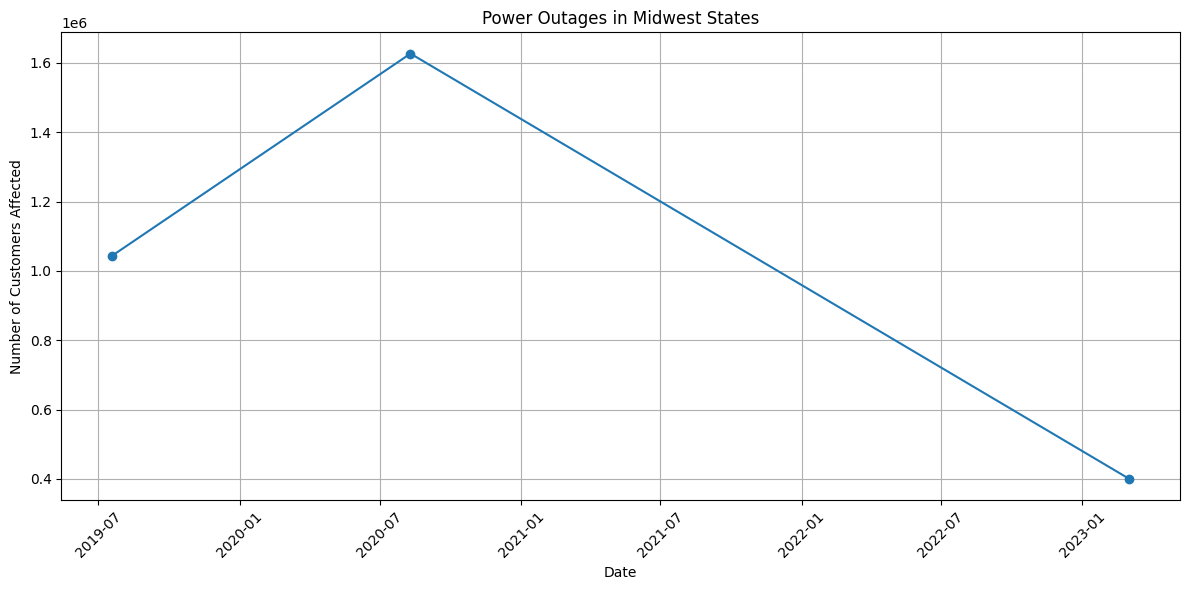

In [62]:
import matplotlib.pyplot as plt
from datetime import datetime

dates = []
customers_affected = []

for event in midwest_events:
    if "Event Dates" in event and "Total Midwest Customers Affected" in event:
        date_str = event["Event Dates"].split(" - ")[0]
        date = datetime.strptime(date_str, "%Y/%m/%d")
        dates.append(date)
        customers_affected.append(event["Total Midwest Customers Affected"])

sorted_data = sorted(zip(dates, customers_affected))
x_data, y_data = zip(*sorted_data)

plt.figure(figsize=(12, 6))
plt.plot(x_data, y_data, marker='o')
plt.title("Power Outages in Midwest States")
plt.xlabel("Date")
plt.ylabel("Number of Customers Affected")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Power Outages for Southern States**

In [67]:
import requests
from bs4 import BeautifulSoup

southern_states = [
    "Florida", "Georgia", "Alabama", "Mississippi", "Louisiana",
    "Texas", "Arkansas", "South Carolina", "North Carolina", "Tennessee"
]

url = "https://poweroutage.com/about/majorevents"

response = requests.get(url)

if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, "html.parser")

    southern_events = []

    containers = soup.find_all("div", class_="col-md-12")

    for container in containers:
        event_data = {}

        event_name = container.find("h3")
        event_data["Event Name"] = event_name.text.strip() if event_name else None

        details = container.find("p")
        if details:
            for line in details.text.split("\n"):
                if "Event:" in line:
                    event_data["Event Dates"] = line.replace("Event:", "").strip()
                elif "Recovery:" in line:
                    event_data["Recovery Dates"] = line.replace("Recovery:", "").strip()

        h4_tags = container.find_all("h4")
        for h4 in h4_tags:
            text = h4.text.strip()
            if "Max Outage Count" in text:
                event_data["Max Outage Count"] = text.replace("Max Outage Count", "").strip()
            elif "Total Customers Affected" in text:
                event_data["Total Customers Affected"] = text.replace("Total Customers Affected:", "").strip()
            elif "Estimated People Affected" in text:
                event_data["Estimated People Affected"] = text.replace("Estimated People Affected:", "").strip()

        southern_states_data = []
        table = container.find("table")
        if table:
            rows = table.find_all("tr")[1:]
            for row in rows:
                columns = row.find_all("td")
                if len(columns) >= 2:
                    state = columns[0].text.strip()
                    affected = columns[1].text.strip()
                    if state in southern_states:
                        southern_states_data.append({"State": state, "Customers Affected": affected})
            event_data["States Affected"] = southern_states_data

        if southern_states_data:
            southern_events.append(event_data)

    for event in southern_events:
        print(event)
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")


{'Event Name': 'Hurricane Helene', 'Event Dates': '2024/09/26 - 2024/09/28', 'Recovery Dates': '2024/09/27 - 2024/10/12', 'Max Outage Count': '4.79 Million', 'Total Customers Affected': 'Over 7.4 Million', 'Estimated People Affected': 'Over 16.2 Million', 'States Affected': [{'State': 'Florida', 'Customers Affected': '1.69 Million'}, {'State': 'South Carolina', 'Customers Affected': '1.59 Million'}, {'State': 'Georgia', 'Customers Affected': '1.28 Million'}, {'State': 'North Carolina', 'Customers Affected': '1.18 Million'}]}
{'Event Name': '2023 March Winter Event', 'Event Dates': '2023/03/03 - 2023/03/04', 'Recovery Dates': '2023/03/04 - 2023/03/07', 'Max Outage Count': '1.5 Million', 'Total Customers Affected': 'Over 4.3 Million', 'Estimated People Affected': 'Over 9 Million', 'States Affected': [{'State': 'Tennessee', 'Customers Affected': '580 Thousand'}, {'State': 'Texas', 'Customers Affected': '570 Thousand'}]}
{'Event Name': '2022 December winter storm', 'Event Dates': '2022/12/

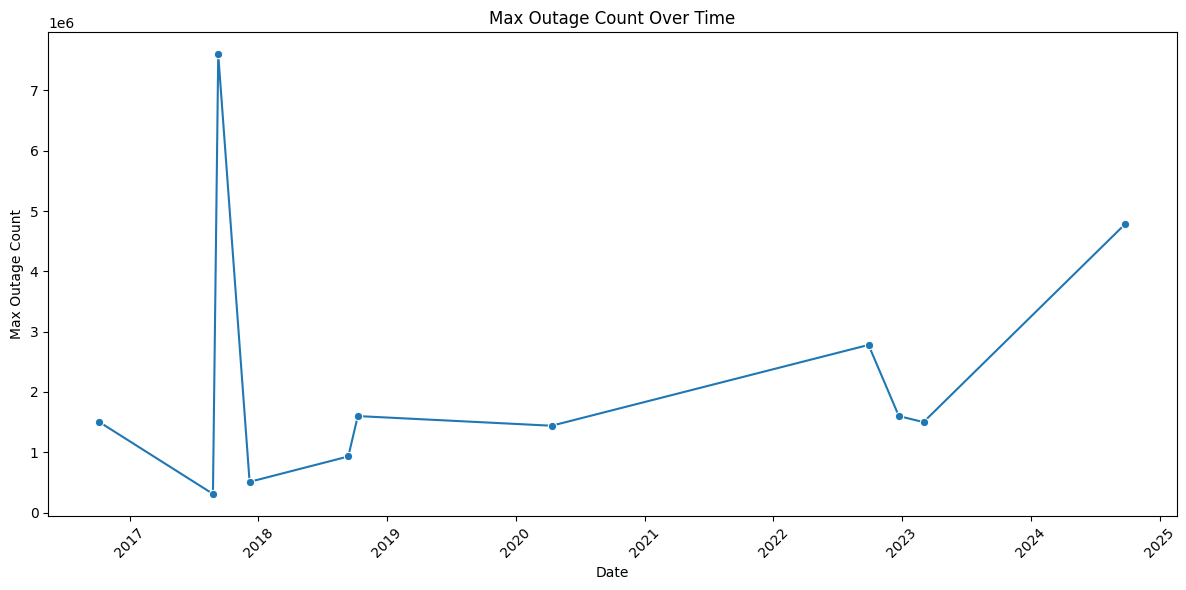

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

data = [
    {'Event Name': 'Hurricane Helene',
     'Event Dates': '2024/09/26 - 2024/09/28',
     'Recovery Dates': '2024/09/27 - 2024/10/12',
     'Max Outage Count': '4.79 Million',
     'Total Customers Affected': 'Over 7.4 Million',
     'Estimated People Affected': 'Over 16.2 Million',
     'States Affected': [{'State': 'Florida', 'Customers Affected': '1.69 Million'},
                         {'State': 'South Carolina', 'Customers Affected': '1.59 Million'},
                         {'State': 'Georgia', 'Customers Affected': '1.28 Million'},
                         {'State': 'North Carolina', 'Customers Affected': '1.18 Million'}]},

    {'Event Name': '2023 March Winter Event',
     'Event Dates': '2023/03/03 - 2023/03/04',
     'Recovery Dates': '2023/03/04 - 2023/03/07',
     'Max Outage Count': '1.5 Million',
     'Total Customers Affected': 'Over 4.3 Million',
     'Estimated People Affected': 'Over 9 Million',
     'States Affected': [{'State': 'Tennessee', 'Customers Affected': '580 Thousand'},
                         {'State': 'Texas', 'Customers Affected': '570 Thousand'}]},

    {'Event Name': '2022 December winter storm',
     'Event Dates': '2022/12/23 - 2022/12/25',
     'Recovery Dates': '2022/12/23 - 2022/12/27',
     'Max Outage Count': '1.6 M',
     'Total Customers Affected': 'Over 6.35 Million',
     'Estimated People Affected': 'Over 13.33 Million',
     'States Affected': [{'State': 'North Carolina', 'Customers Affected': '940 Thousand'},
                         {'State': 'Tennessee', 'Customers Affected': '710 Thousand'}]},

    {'Event Name': 'Hurricane Ian',
     'Event Dates': '2022/09/28 - 2022/10/01',
     'Recovery Dates': '2022/09/29 - 2022/10/06',
     'Max Outage Count': '2.78 M',
     'Total Customers Affected': "Over 4.45 Million",
     "Estimated People Affected": "Over 9.62 Million",
     "States Affected": [{'State':'Florida','Customers Affected':'3.28 Million'},
                         {'State':'North Carolina','Customers Affected':'579 Thousand'},
                         {'State':'South Carolina','Customers Affected':'378 Thousand'}]},

    {'Event Name':'April 2020 Major Storm',
      "Event Dates":"2020/04/12 - 2019/04/14",
      "Recovery Dates":"2019/04/14 - 2019/04/17",
      "Max Outage Count":"1.44 Million",
      "Total Customers Affected":"Over 4.3 Million", # Fixed this line
      "Estimated People Affected":"Over 9.3 Million",
      "States Affected":[{'State':'North Carolina','Customers Affected':'399 Thousand'},
                         {'State':'South Carolina','Customers Affected':'391 Thousand'},
                         {'State':'Texas','Customers Affected':'353 Thousand'},
                         {'State':'Alabama','Customers Affected':'243 Thousand'}]},

    {'Event Name':'Hurricane Michael',
      "Event Dates":"2018/10/10 - 2018/10/12",
      "Recovery Dates":"2018/10/12 - 2018/10/25",
      "Max Outage Count":"1.6 Million",
      "Total Customers Affected":"Over 3.1 Million", # Fixed this line
      "Estimated People Affected":"Over 6.8 Million",
      "States Affected":[{'State':'North Carolina','Customers Affected':'843 Thousand'},
                         {'State':'Florida','Customers Affected':'672 Thousand'},
                         {'State':'Georgia','Customers Affected':'512 Thousand'}]},

    {'Event Name':'Hurricane Florence',
      "Event Dates":"2018/09/13 - 2018/09/14",
      "Recovery Dates":"2018/09/14 - 2018/09/22",
      "Max Outage Count":"930 Thousand",
      "Total Customers Affected":"Over 1.4 Million", # Fixed this line
      "Estimated People Affected":"Over 3.1 Million",
      "States Affected":[{'State':'North Carolina','Customers Affected':'769 Thousand'},
                         {'State':'South Carolina','Customers Affected':'156 Thousand'}]},

    {'Event Name':'Snow Storm Benji',
      "Event Dates":"2017/12/07 - 2017/12/09",
      "Recovery Dates":"2017/12/09 - 2017/12/11",
      "Max Outage Count":"509 Thousand",
      "Total Customers Affected":"Over 910 Thousand", # Fixed this line
      "Estimated People Affected":"Over 1.9 Million",
      "States Affected":[{'State':'Georgia','Customers Affected':'289167'},
                         {'State':'Texas','Customers Affected':'105809'},
                         {'State':'Louisiana','Customers Affected':'104261'}]},

    {'Event Name':'Hurricane Irma',
      "Event Dates":"2017/09/09 - 2017/09/11",
      "Recovery Dates":"2017/09/11 - 2017/09/23",
      "Max Outage Count":"7.6 Million",
      "Total Customers Affected": None, # Adjusted for missing data
      "States Affected":[{'State':'Florida','Customers Affected':'6051232'},
                         {'State':'Georgia','Customers Affected':'1329496'},
                         {'State':'South Carolina','Customers Affected':'273733'}]},

    {'Event Name':'Hurricane Harvey',
      "Event Dates":"2017/08/25 - 2017/08/29",
      "Recovery Dates":"2017/08/29 - 2017/09/12",
      "Max Outage Count":"309 Thousand",
      "Total Customers Affected": None, # Adjusted for missing data
      "States Affected":[{'State':'Texas','Customers Affected':'309204'}]},

    {'Event Name':'Hurricane Matthew',
      "Event Dates":"2016/10/07 - 2016/10/08",
      "Max Outage Count":"1.5 Million",
      "Total Customers Affected": None, # Adjusted for missing data
      "States Affected":[{'State':'Florida','Customers Affected':'850000'},
                         {'State':'South Carolina','Customers_Affected ':'400000'},
                         {'State ':'Georgia ','Customers_Affected ':'330000'}]}
]

def parse_number(text):
    if text is None:
        return 0

    text = text.replace(',', '').strip()

    if any(x in text for x in ["Million", "M"]):
        number_part = text.split("Million")[0].split("M")[0].strip()
        return int(float(number_part.replace("Over", "").strip()) * 1_000_000)

    elif any(x in text for x in ["Thousand", "K"]):
        number_part = text.split("Thousand")[0].split("K")[0].strip()
        return int(float(number_part.replace("Over", "").strip()) * 1_000)

    elif "Over" in text:
        number_part = text.split("Over")[-1].strip()
        return parse_number(number_part)

    elif text.isdigit() or (text.replace('.', '', 1).isdigit()):
        return int(float(text))

    print(f"Warning: Could not parse number from '{text}'")
    return 0

event_names = []
event_dates = []
max_outage_counts = []
total_customers_affected = []
recovery_times = []

for event in data:
    event_names.append(event['Event Name'])

    start_date_str, end_date_str = event['Event Dates'].split(' - ')
    event_dates.append(datetime.strptime(start_date_str, "%Y/%m/%d"))

    max_outage_counts.append(parse_number(event['Max Outage Count']))
    total_customers_affected.append(parse_number(event['Total Customers Affected']))


plt.figure(figsize=(12,6))
sns.lineplot(x=event_dates, y=max_outage_counts, marker='o')
plt.title('Max Outage Count Over Time')
plt.xlabel('Date')
plt.ylabel('Max Outage Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




